# Machine Learning to Predict auction volumes

Edgar Jullien, Antoine Settelen, Simon Weiss



## Introduction

### Challenge context

In many stock exchanges, at the end of a trading day, **auction takes place for each stock**. Each stock is then exchanged at a single price, based on the interest that market participants show in the auction.

It is advantageous to do some trading during this auction instead of during the preceding continuous trading, as trading costs are usually lower.

In addition, some market participants (day traders, market makers…) prefer to not hold stocks overnight, because events might affect the stock price between the close of the market and the price at the open on the next day (elections, company announcements, etc.), which may result in a loss. For these market participants, the auction is the last chance to limit such a risk, as it is an opportunity to get rid of their remaining stocks and not hold any overnight.

For market participants that instead want to hold a specific number of stocks by the end of the day (asset managers…), the auction is their last chance to reach this target. This is in principle important, because they have optimized this number of stocks to hold. For example, if they predict that the price of a stock should rise, then it is in their interest to buy as much of the stock as possible, within the limits set by how much they can invest and by the financial risk that they are ready to take.

Market participants may thus want to **estimate the expected number of stocks available during the auction**, as this allows them to gauge how many they can hope to buy or sell during this final, financially advantageous trading opportunity.


#### Challenge goals


The goal of this challenge is to predict the volume (total value of stock exchanged) available for auction, for **900 stocks** over about **350 days**.
Data description

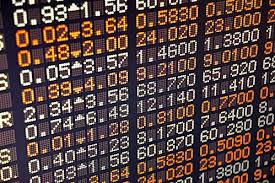

### Data descritpion





**Input data**

The prediction of the auction volume for a given stock on a given day can be made based on the following 126 input columns:

    pid: a Product ID, that represents a stock.
    day: day of the data sample, as an integer. The ordering is chronological, with day 0 coming before day 1, etc.
    abs_retn (n from 0 to 60): absolute values of stock returns (relative price change) between the last known price (typically the price at the beginning of period n) and the end of period n (as a percentage), where the periods cover a good part of the trading day, don't overlap, and have the same duration. Return n=0 comes before return n=1, etc.
    rel_voln: like abs_retn, but represents the traded stock volume as a fraction of the volume traded during the period covered (thus, they sum to 1, over a day). The periods are the same as for the returns.
    LS and NLV: two quantities associated with the trades of the day for the stock in question. Their nature is kept undisclosed for this challenge.

**Output data**

The output data contains, for a given stock and a given day, the natural logarithm of the auction volume (= total value of traded stocks), as a fraction of the total volume in the 61 given periods. Thus, if the auction volume represents 10 % of the volume traded over all the periods of a day, the target is log 0.10 = -2.30…

Training and test data

The 900 stocks found in the training and test data are the same: it is therefore in principle possible to devise predictions that are customized for each stock.

The training data contains information on about 800 different days, while the test data requires auction volume predictions for about 350 days.

Furthermore, the test inputs correspond to days that come after those of the training data. A challenge is that auction volumes can evolve over time (for instance by becoming relatively larger and larger over time), but we only see what the past (training) auction volumes looks like.

### Ideas from challenge prez and AMF report about fixing volume

*Presentation ideas :*
- the evolution of the volume in the future is not necessarily linear.
=> Feature: Evolution of the global volume per day

- For a given day (see idea amf report, election), the market can behave in a particular way that can have csq on the volume. 


- For boosted trees, bad for extrapolations on future data (in a particular domain).
=> They can be combined with other algoes


*Ideas from AMF report (only for France):*



- In a given quarter, the auction share for end-of-quarter months (March, June, September and December) is about 4% to 6% higher than that observed for the other months (bc of derivative product)
=> Fature Need quarter feature encode / months

- The days on which quarterly derivatives expire are not only amongst the most active days, they are also the days on which the share of the closing auction reaches its highest level cf graph amf

=> Encode these specific days

- last trading day of the months of February, May, August and November are also among the most active days in terms of volumes traded (to a lesser extent than for quarterly expiries) and those with the largest share of the fixing
This comes from The MSCI indices rebalancing days

=> Encode these specific days


- In contrast, on days of high volatility and large volumes (e.g. start of February 2018 and around the first round of the French presidential elections), 
the share of the closing auction is generally lower than the average on the other days.

Origin  : 

- RAPID DEVELOPMENT OF PASSIVE MANAGEMENT in Europe notably the ETF which have to increase their volume at the end of the day (vs US)
=> If we have the days, we could add the share of passive funds in equity funds

- Best Exectution obligation : since the closing auction offers a single simple reference price.

- Avoiding HTF

- THE AMPLIFYING EFFECT OF EXECUTION ALGORITHMS
VWAP type, which adapt their execution volumes to that of the market in general

=> Newcolumn : Abs_var_price* Abs_vol


- Check TOP & TOV formation in doc. 

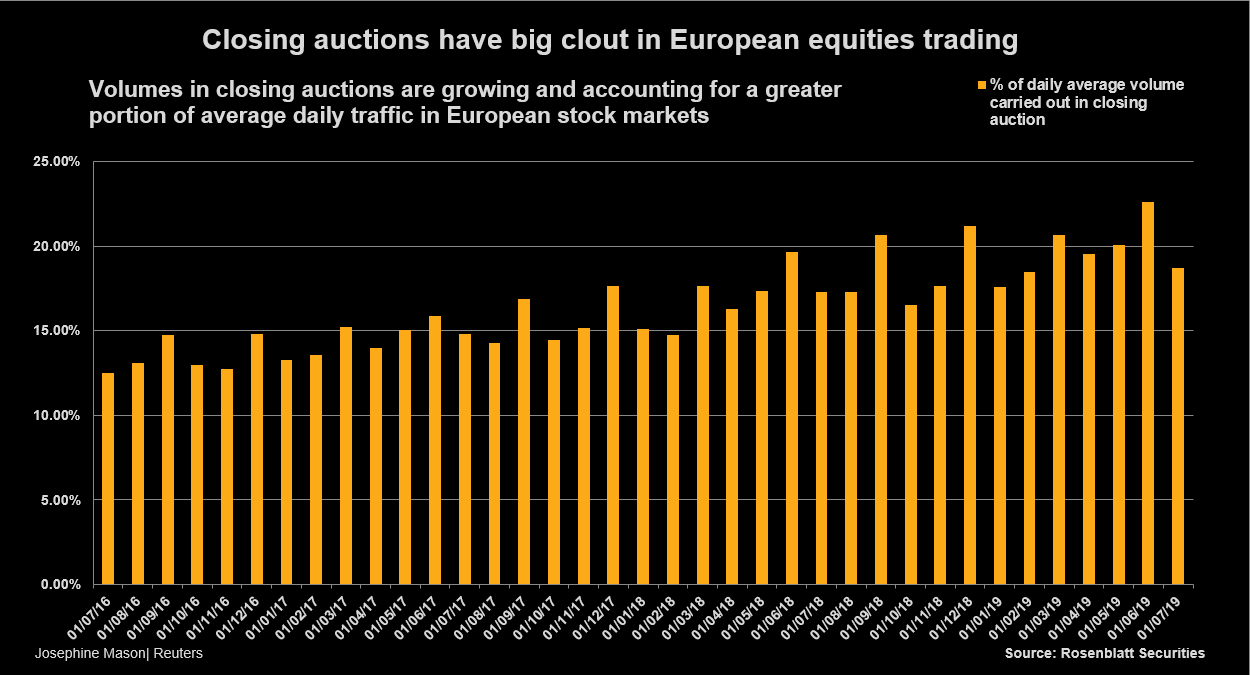

https://fingfx.thomsonreuters.com/gfx/mkt/12/4751/4713/closing%20auctions.png

### Description of the steps : 



- Step 0 : load drive in google collab
- Step 1 : Implement benchmark methodology used by challenge provider
- Step 2 : Advanced feature engineering
- Step 3 : Advanced Machine Learning modeling
- Step 4 : Deep learning : LTSM with Pytorch

### Results

- Benchmark : 15th in leaderboard (submission 01.02, 5:30pm) - MSE : 0.5723
- Advanced Machine Learning : 10th in leaderboard (submission 12.02, 7:37pm) - MSE : 0.4909
- Deep Learning : 21th in leaderboard (submission 14.02, 2.37pm, MSE : 0.631259918503299

### Set- up used : 
- Google collab pro GPU
- a lot of coffee

## Step 0 : Load drive

In [67]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Step 1. Benchmark

### Task 1 : Load libraries & dataset

In [65]:
#pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.24.1)


In [66]:
#pip install delayed

In [69]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
import xgboost
from sklearn.model_selection import train_test_split
import delayed
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score 
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.datasets import make_moons
from sklearn.model_selection import RandomizedSearchCV


Load Light GBM in Google collab for futur use of GPU

In [ ]:
"""!rm -r /content/LightGBM
!git clone --recursive https://github.com/Microsoft/LightGBM
%cd /content/LightGBM
!mkdir build
!cmake -DUSE_GPU=1 #avoid ..
!make -j$(nproc)
!sudo apt-get -y install python-pip
!sudo -H pip install setuptools pandas numpy scipy scikit-learn -U
%cd /content/LightGBM/python-package
!sudo python setup.py install --precompile"""

'!rm -r /content/LightGBM\n!git clone --recursive https://github.com/Microsoft/LightGBM\n%cd /content/LightGBM\n!mkdir build\n!cmake -DUSE_GPU=1 #avoid ..\n!make -j$(nproc)\n!sudo apt-get -y install python-pip\n!sudo -H pip install setuptools pandas numpy scipy scikit-learn -U\n%cd /content/LightGBM/python-package\n!sudo python setup.py install --precompile'

In [70]:
data_dir  = "/content/drive/MyDrive/U4_Prediction_stock_auction_volumes/dataset"

In [71]:
data_list = glob.glob(os.path.join(data_dir, '**.csv'))
data_list

['/content/drive/MyDrive/U4_Prediction_stock_auction_volumes/dataset/x_train.csv',
 '/content/drive/MyDrive/U4_Prediction_stock_auction_volumes/dataset/x_test.csv',
 '/content/drive/MyDrive/U4_Prediction_stock_auction_volumes/dataset/submission_csv_file_random_example.csv',
 '/content/drive/MyDrive/U4_Prediction_stock_auction_volumes/dataset/y_train.csv']

In [88]:
y_train = pd.read_csv("%s/y_train.csv" % data_dir, sep=",")
x_train = pd.read_csv("%s/x_train.csv" % data_dir, sep=",")
x_test=pd.read_csv("%s/x_test.csv" % data_dir, sep=",")

### Task 2  : feature engineering

#### 2.1 Missing values

In [89]:
np.any(np.isnan(x_train))

True

In [90]:
x_train.fillna(0, inplace=True) 
x_test.fillna(0, inplace=True)

#### 2.2 Basic feature engineering

We create min, max, std and median for the volume

In [91]:
x_train['min_ret']    = np.min(x_train.iloc[:,3:63], axis=1)
x_train['max_ret']    = np.max(x_train.iloc[:,3:63], axis=1)
x_train['std_ret']    = np.std(x_train.iloc[:,3:63], axis=1)
x_train['median_ret'] = np.median(x_train.iloc[:,3:63], axis=1)
x_train['sum_ret'] = np.median(x_train.iloc[:,3:63], axis=1)

In [92]:
x_test['min_ret']    = np.min(x_train.iloc[:,3:63], axis=1)
x_test['max_ret']    = np.max(x_test.iloc[:,3:63], axis=1)
x_test['std_ret']    = np.std(x_test.iloc[:,3:63], axis=1)
x_test['median_ret'] = np.median(x_test.iloc[:,3:63], axis=1)

In [93]:
x_train['min_vol']    = np.min(x_train.iloc[:,64:125], axis=1)
x_train['max_vol']    = np.max(x_train.iloc[:,64:125], axis=1)
x_train['std_vol']    = np.std(x_train.iloc[:,64:125], axis=1)
x_train['median_vol'] = np.median(x_train.iloc[:,64:125], axis=1)

In [94]:
x_test['min_vol']    = np.min(x_test.iloc[:,64:125], axis=1)
x_test['max_vol']    = np.max(x_test.iloc[:,64:125], axis=1)
x_test['std_vol']    = np.std(x_test.iloc[:,64:125], axis=1)
x_test['median_vol'] = np.median(x_test.iloc[:,64:125], axis=1)

We Convert pid (categorical variable) to dummies for XGboost (doesn't take cat features)

In [95]:
train_dataset = y_train.merge(x_train, on="ID")

In [98]:
x_train.drop(['sum_ret'], axis=1, inplace=True)

KeyError: ignored

In [100]:
x_train=pd.get_dummies(x_train,columns=['pid'])
x_test=pd.get_dummies(x_test,columns=['pid'])

In [101]:
for f in x_train.columns[134:1034]:
  x_train[f]=x_train[f].astype('category')

In [103]:
for f in x_test.columns[134:1034]:
  x_test[f]=x_test[f].astype('category')

In [102]:
x_train 

,ID,day,abs_ret0,abs_ret1,abs_ret2,abs_ret3,abs_ret4,abs_ret5,abs_ret6,abs_ret7,abs_ret8,abs_ret9,abs_ret10,abs_ret11,abs_ret12,abs_ret13,abs_ret14,abs_ret15,abs_ret16,abs_ret17,abs_ret18,abs_ret19,abs_ret20,abs_ret21,abs_ret22,abs_ret23,abs_ret24,abs_ret25,abs_ret26,abs_ret27,abs_ret28,abs_ret29,abs_ret30,abs_ret31,abs_ret32,abs_ret33,abs_ret34,abs_ret35,abs_ret36,abs_ret37,...,pid_860,pid_861,pid_862,pid_863,pid_864,pid_865,pid_866,pid_867,pid_868,pid_869,pid_870,pid_871,pid_872,pid_873,pid_874,pid_875,pid_876,pid_877,pid_878,pid_879,pid_880,pid_881,pid_882,pid_883,pid_884,pid_885,pid_886,pid_887,pid_888,pid_889,pid_890,pid_891,pid_892,pid_893,pid_894,pid_895,pid_896,pid_897,pid_898,pid_899
0,148,0,0.000000,0.000000,0.000000,0.000000,0.029317,0.000000,0.000000,0.000000,0.000000,0.073260,0.073265,0.000000,0.036601,0.102399,0.029261,0.000000,0.073206,0.032942,0.036609,0.000000,0.014641,0.036643,0.000000,0.036630,0.007326,0.000000,0.000000,0.000000,0.000000,0.000000,0.014656,0.000000,0.000000,0.000000,0.000000,0.021989,0.036627,0.018305,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,149,1,0.000000,0.000000,0.000000,0.022056,0.000000,0.036711,0.000000,0.000000,0.036767,0.000000,0.058949,0.000000,0.014700,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014743,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014802,0.014818,0.000000,0.000000,0.022168,0.000000,0.000000,0.000000,0.051764,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,150,2,0.000000,0.000000,0.000000,0.000000,0.022267,0.000000,0.029678,0.014831,0.048146,0.092654,0.000000,0.000000,0.000000,0.051902,0.000000,0.022270,0.000000,0.118457,0.059084,0.000000,0.000000,0.014806,0.000000,0.022166,0.000000,0.000000,0.000000,0.000000,0.029588,0.044418,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,151,3,0.000000,0.007384,0.000000,0.000000,0.000000,0.007417,0.000000,0.044557,0.052169,0.044613,0.000000,0.000000,0.000000,0.000000,0.007423,0.000000,0.000000,0.007447,0.000000,0.000000,0.007418,0.000000,0.000000,0.000000,0.000000,0.007389,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007362,0.000000,0.000000,0.036824,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,152,4,0.088086,0.109737,0.000000,0.014648,0.003662,0.036627,0.007319,0.197325,0.094835,0.029218,0.000000,0.000000,0.000000,0.050850,0.000000,0.000000,0.098100,0.058245,0.007266,0.018169,0.007283,0.014541,0.000000,0.000000,0.000000,0.000000,0.000000,0.076542,0.182548,0.000000,0.051136,0.007305,0.000000,0.000000,0.000000,0.051230,0.036611,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
684477,1536855,800,1.125704,0.865801,0.000000,0.124611,0.124456,0.000000,0.062344,0.124533,0.124688,0.374532,0.876644,0.248293,0.000000,0.435594,0.743494,0.187266,0.249221,0.062112,0.186451,0.000000,0.248139,0.123762,0.061958,0.124378,0.000000,0.124301,0.061920,0.000000,0.061920,0.061958,0.123839,0.494743,0.093226,0.093139,0.062035,0.123993,0.186220,0.186683,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
684478,1536856,801,0.000000,0.746269,0.502197,0.441640,0.000000,0.125392,0.187852,0.062735,0.690521,0.124844,0.125000,0.000000,0.124844,0.000000,0.310945,0.247219,0.185874,0.000000,0.124069,0.186567,0.186220,0.062035,0.124146,0.186451,0.249066,0.312110,0.124456,0.062305,0.062305,0.373832,0.000000,0.062539,0.062500,0.000000,0.125235,0.250156,0.000000,0.0

#### 2.3 Create split for training and testing

First we merge x_train and y_train and drop ID columns

In [104]:
train_df  = y_train.merge(x_train, on="ID")
train_df.drop(['ID'], axis=1, inplace=True)

In [105]:
train_X_, test_X_, train_y_, test_y_ = train_test_split(train_df.iloc[:,1:134], train_df['target'], test_size=0.2, random_state=42)

In [106]:
import delayed

### Task 3 : EDA

EDA inspired from https://www.kaggle.com/gopidurgaprasad/m5-forecasting-eda-lstm-pytorch-modeling

For EDA we are going to use one of pid  
We are going to use pid 10





In [107]:
pid_10=train_dataset[train_dataset['pid']==10]

In [108]:
pid_10.head()

,ID,target,pid,day,abs_ret0,abs_ret1,abs_ret2,abs_ret3,abs_ret4,abs_ret5,abs_ret6,abs_ret7,abs_ret8,abs_ret9,abs_ret10,abs_ret11,abs_ret12,abs_ret13,abs_ret14,abs_ret15,abs_ret16,abs_ret17,abs_ret18,abs_ret19,abs_ret20,abs_ret21,abs_ret22,abs_ret23,abs_ret24,abs_ret25,abs_ret26,abs_ret27,abs_ret28,abs_ret29,abs_ret30,abs_ret31,abs_ret32,abs_ret33,abs_ret34,abs_ret35,...,rel_vol32,rel_vol33,rel_vol34,rel_vol35,rel_vol36,rel_vol37,rel_vol38,rel_vol39,rel_vol40,rel_vol41,rel_vol42,rel_vol43,rel_vol44,rel_vol45,rel_vol46,rel_vol47,rel_vol48,rel_vol49,rel_vol50,rel_vol51,rel_vol52,rel_vol53,rel_vol54,rel_vol55,rel_vol56,rel_vol57,rel_vol58,rel_vol59,rel_vol60,LS,NLV,min_ret,max_ret,std_ret,median_ret,sum_ret,min_vol,max_vol,std_vol,median_vol
63938,125243,-1.755755,10,0,0.0,0.0,0.305111,0.152323,0.000000,0.000000,0.000000,0.153022,0.076570,0.076394,0.0,0.153022,0.0,0.000000,0.076104,0.000000,0.07622,0.076104,0.0,0.075988,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.378501,0.000000,0.113165,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.004495,0.005998,0.018136,0.003082,0.000997,0.011446,0.011898,0.005984,0.005126,0.003992,0.006987,0.011027,0.003983,0.020535,0.001426,0.020922,0.010839,0.006792,0.011312,0.010480,0.010054,0.049389,0.016689,0.017533,0.030076,0.014692,0.011263,0.008003,0.011122,-4.116767,-0.923613,0.0,0.378501,0.072113,0.0,0.0,0.000997,0.094261,0.014706,0.011701
63939,125244,-2.587678,10,1,0.0,0.0,0.000000,0.076453,0.152439,0.381971,0.530705,0.075700,0.000000,0.000000,0.0,0.000000,0.0,0.076336,0.191424,0.038476,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.076687,0.076982,0.000000,0.000000,0.076864,0.000000,0.0,0.00000,0.076923,0.000000,0.000000,0.000000,...,0.009695,0.005734,0.001794,0.009835,0.002870,0.006175,0.006578,0.004650,0.009060,0.005970,0.002870,0.019403,0.005042,0.007191,0.007745,0.004510,0.009828,0.007833,0.004306,0.007196,0.009422,0.011843,0.002154,0.006461,0.018719,0.009347,0.010604,0.005758,0.007367,-4.046217,-0.730793,0.0,0.530705,0.088889,0.0,0.0,0.001181,0.180957,0.027686,0.009052
63940,125245,-2.504335,10,2,0.0,0.0,0.000000,0.153846,0.153728,0.000000,0.153846,0.230415,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.076864,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.076336,0.0,0.00000,0.000000,0.000000,0.000000,0.151976,...,0.045857,0.006442,0.007742,0.021287,0.013380,0.007059,0.001283,0.007707,0.009312,0.005260,0.004560,0.000758,0.005249,0.011068,0.005762,0.004485,0.013425,0.000640,0.003839,0.008496,0.002559,0.026246,0.005921,0.003573,0.003203,0.010302,0.038486,0.008936,0.015049,-4.355014,-1.086094,0.0,0.230415,0.049749,0.0,0.0,0.000000,0.090617,0.017319,0.010956
63941,125246,-2.121251,10,3,0.0,0.0,0.000000,0.000000,0.000000,0.302343,0.152091,0.076220,0.380228,0.000000,0.0,0.000000,0.0,0.076628,0.000000,0.000000,0.00000,0.000000,0.0,0.076923,0.038417,0.0,0.000000,0.0,0.000000,0.000000,0.076746,0.000000,0.000000,0.076394,0.0,0.00000,0.303260,0.000000,0.151515,0.075815,...,0.012009,0.005775,0.010576,0.013792,0.048989,0.028612,0.004822,0.005307,0.002253,0.008672,0.013209,0.003383,0.001964,0.008393,0.003257,0.006744,0.003995,0.004182,0.010214,0.005156,0.008357,0.016448,0.008528,0.007478,0.012009,0.012925,0.088387,0.018533,0.030084,-4.215094,-0.650578,0.0,0.380228,0.077397,0.0,0.0,0.001904,0.088387,0.015839,0.012328
63942,125247,-1.833420,10,4,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.073964,0.0,0.073964,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.073964,0.0,0.000000,0.074019,0.000000,0.073964,0.000000,0.000000,0.0,0.07391,0.000000,0.074129,0.000000,0.000000,...,0.009347,0.021231,0.001871,0.015303,0.012233,0.011776,0.004607,0.008698,0.005600,0.015556,0.008332,0.003728,0.013649,0.007445,0.037189,0.085508,0.022920,0.000619,0.006204,0.015138,0.009299,0.006120,0.004956,0.008090,0.001363,0.028867,0.010017,0.005579,0.017945,-4.138836,-1.050539,0.0,0.148920,

In [109]:
day_sum = pid_10.groupby("day")[["sum_ret", "median_vol"]].agg("sum").reset_index()

In [111]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [112]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Scatter(x=day_sum.day, 
                         y=day_sum.median_vol,
                         #showlegend=False,
                         mode="lines",
                         name="median_vol",
                         #marker=dict(color="mediumseagreen"),
                         ),

              row=1,col=1         
              )

fig.add_trace(go.Scatter(x=day_sum.day, 
                         y=day_sum.sum_ret,
                         #showlegend=False,
                         mode="lines",
                         name="sum_ret",
                         #marker=dict(color="mediumseagreen")
                         ),
             
              row=2,col=1           
              )

fig.update_layout(height=1000, title_text="SUM -> Demand  and Sell_price")
fig.show()

In [ ]:
Observation

 

Plot 

In [125]:
train_dataset

,ID,target,pid,day,abs_ret0,abs_ret1,abs_ret2,abs_ret3,abs_ret4,abs_ret5,abs_ret6,abs_ret7,abs_ret8,abs_ret9,abs_ret10,abs_ret11,abs_ret12,abs_ret13,abs_ret14,abs_ret15,abs_ret16,abs_ret17,abs_ret18,abs_ret19,abs_ret20,abs_ret21,abs_ret22,abs_ret23,abs_ret24,abs_ret25,abs_ret26,abs_ret27,abs_ret28,abs_ret29,abs_ret30,abs_ret31,abs_ret32,abs_ret33,abs_ret34,abs_ret35,...,rel_vol32,rel_vol33,rel_vol34,rel_vol35,rel_vol36,rel_vol37,rel_vol38,rel_vol39,rel_vol40,rel_vol41,rel_vol42,rel_vol43,rel_vol44,rel_vol45,rel_vol46,rel_vol47,rel_vol48,rel_vol49,rel_vol50,rel_vol51,rel_vol52,rel_vol53,rel_vol54,rel_vol55,rel_vol56,rel_vol57,rel_vol58,rel_vol59,rel_vol60,LS,NLV,min_ret,max_ret,std_ret,median_ret,sum_ret,min_vol,max_vol,std_vol,median_vol
0,148,-3.403606,360,0,0.000000,0.000000,0.000000,0.000000,0.029317,0.000000,0.000000,0.000000,0.000000,0.073260,0.073265,0.000000,0.036601,0.102399,0.029261,0.000000,0.073206,0.032942,0.036609,0.000000,0.014641,0.036643,0.000000,0.036630,0.007326,0.000000,0.000000,0.000000,0.000000,0.000000,0.014656,0.000000,0.000000,0.000000,0.000000,0.021989,...,0.014621,0.004915,0.009695,0.014404,0.011438,0.005018,0.003520,0.006112,0.001629,0.007395,0.007272,0.017971,0.007965,0.003240,0.008937,0.008786,0.009677,0.008480,0.011040,0.004054,0.009431,0.004521,0.015771,0.009462,0.012697,0.019507,0.005101,0.010654,0.006971,-2.307230,0.646580,0.0,0.102399,0.022135,0.000000,0.000000,0.001629,0.076994,0.014242,0.011438
1,149,-2.904798,360,1,0.000000,0.000000,0.000000,0.022056,0.000000,0.036711,0.000000,0.000000,0.036767,0.000000,0.058949,0.000000,0.014700,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014743,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014802,0.014818,0.000000,0.000000,0.022168,0.000000,0.000000,0.000000,...,0.010928,0.004953,0.001122,0.007357,0.032969,0.004212,0.004200,0.002189,0.004183,0.000931,0.000753,0.008522,0.011424,0.042281,0.003987,0.002132,0.003802,0.003952,0.009427,0.017466,0.023188,0.008817,0.006589,0.005276,0.011648,0.011829,0.015558,0.001788,0.005251,-2.263960,0.487708,0.0,0.058949,0.013334,0.000000,0.000000,0.000753,0.128265,0.023473,0.008817
2,150,-2.337807,360,2,0.000000,0.000000,0.000000,0.000000,0.022267,0.000000,0.029678,0.014831,0.048146,0.092654,0.000000,0.000000,0.000000,0.051902,0.000000,0.022270,0.000000,0.118457,0.059084,0.000000,0.000000,0.014806,0.000000,0.022166,0.000000,0.000000,0.000000,0.000000,0.029588,0.044418,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.004453,0.007961,0.003208,0.006635,0.002473,0.001524,0.007806,0.002231,0.006975,0.004943,0.002252,0.007676,0.022513,0.124384,0.017086,0.023940,0.036648,0.025713,0.020880,0.009542,0.006752,0.018640,0.020972,0.012728,0.007921,0.000643,0.029692,0.016440,0.011970,-2.343106,0.544476,0.0,0.118457,0.024431,0.000000,0.000000,0.000000,0.124384,0.017673,0.010645
3,151,-2.285676,360,3,0.000000,0.007384,0.000000,0.000000,0.000000,0.007417,0.000000,0.044557,0.052169,0.044613,0.000000,0.000000,0.000000,0.000000,0.007423,0.000000,0.000000,0.007447,0.000000,0.000000,0.007418,0.000000,0.000000,0.000000,0.000000,0.007389,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007362,0.000000,0.000000,...,0.009762,0.016240,0.012835,0.008973,0.023312,0.003007,0.009878,0.011719,0.009139,0.006265,0.010273,0.012355,0.011745,0.001635,0.005562,0.007811,0.010685,0.062768,0.072686,0.009503,0.017088,0.013628,0.020397,0.016834,0.031869,0.012468,0.065173,0.048286,0.021237,-2.331621,0.633181,0.0,0.052169,0.012455,0.000000,0.000000,0.001385,0.072686,0.014455,0.011745
4,152,-2.606321,360,4,0.088086,0.109737,0.000000,0.014648,0.003662,0.036627,0.007319,0.197325,0.094835,0.029218,0.000000,0.000000,0.000000,0.050850,0.000000,0.000000,0.098100,0.058245,0.007266,0.018169,0.007283,0.014541,0.000000,0.000000,0.000000,0.000000,0.000000,0.076542,0.182548,0.000000,0.051136,0.007305,0.000000,0.000000,0.000000,0.051230,...,0.002315,0.005078,0.005520,0.015532,0.031905,0.005469,0.015763,0.005532,0.0146

In [132]:
## For each Deportment mean of deman and sell_price

#dep_pid = train_dataset.groupby(["day","pid"])[["sum_ret", "median_vol"]].agg(["mean", "max"]).reset_index()
dep_pid = train_dataset[["day", "pid", "sum_ret", "median_vol"]].reset_index()

In [133]:
dep_pid

,index,day,pid,sum_ret,median_vol
0,0,0,360,0.000000,0.011438
1,1,1,360,0.000000,0.008817
2,2,2,360,0.000000,0.010645
3,3,3,360,0.000000,0.011745
4,4,4,360,0.007275,0.014539
...,...,...,...,...,...
684477,684477,800,596,0.123916,0.013105
684478,684478,801,596,0.124650,0.012639
684479,684479,802,596,0.126342,0.014552
684480,684480,803,596,0.227593,0.012455


In [135]:
fig = make_subplots(rows=1, cols=1)

for pid_i in dep_pid['pid'].unique()[0:2]:
    dep_pid_df = dep_pid[dep_pid['pid']==pid_i]
    fig.add_trace(go.Scatter(x=dep_pid_df["day"], 
                             y=dep_pid_df["median_vol"],
                             #showlegend=Ture,
                             mode="lines",
                             name=str(pid_i),
                             #marker=dict(color="mediumseagreen")
                             ),

                  row=1,col=1         
                  )
    
fig.update_layout(title_text="Vol Mean Over pid by day-by-day")
fig.show()

In [139]:
fig = make_subplots(rows=1, cols=1)

for pid_i in dep_pid['pid'].unique():
    dep_pid_df = dep_pid[dep_pid['pid']==pid_i]
    fig.add_trace(go.Scatter(x=dep_pid_df["day"], 
                             y=dep_pid_df["sum_ret"],
                             #showlegend=Ture,
                             mode="lines",
                             name=str(pid_i),
                             #marker=dict(color="mediumseagreen")
                             ),

                  row=1,col=1         
                  )
    
fig.update_layout(title_text="Sum ret Mean Over pid day-by-day")
fig.show()

Output hidden; open in https://colab.research.google.com to view.

### Task 4 : Linear regression modelling 



We first run a linear regression on our train_dataset in order to get a new error variable that we will try to minimize in a second time with XGboost

#### 3.1 Predict with linear regression

In [140]:
regrLin = LinearRegression()
regrLin.fit(train_X_, train_y_)

LinearRegression()

In [141]:
test_X_['predict'] = regrLin.predict(test_X_)

In [142]:
(mean_squared_error(test_y_, test_X_['predict']))

0.6239513625421437

#### 3.2 Create error variable from linear prediction

In [143]:
test_y_=pd.DataFrame(test_y_)

In [144]:
test_X_['error']=test_y_["target"] - test_X_['predict']

### Task 5 : XGboost for error modelling

#### 5.1 Prepare data for modelling 

Categorize pid in XGboost

In [145]:
test_X_=test_X_.join(train_df[train_df.columns[134:1034]])

Store days for time series split

In [147]:
date_series = test_X_['day']

In [148]:
min_date = date_series.min()
max_date = date_series.max()

In [149]:
dates = list(range(min_date, max_date + 1))
len(dates)

805

Create new train and test dataset from X_test

In [150]:
X_error_train = test_X_[test_X_['day']<=600].drop(['error'], axis = 1)
y_error_train = test_X_[test_X_['day']<=600]['error']

In [151]:
X_error_test = test_X_[test_X_['day']>600].drop(['error'], axis = 1)
y_error_test = test_X_[test_X_['day']>600]['error']

#### 5.2 Xgboost model

In [152]:
def learning_rate_010_decay_power_099(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_010_decay_power_0995(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_005_decay_power_099(current_iter):
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

In [153]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'neg_mean_squared_error', 
            "eval_set" : [(X_error_test,y_error_test)],
            'eval_names': ['valid'],
            'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100,
            'categorical_feature':'auto'}

In [154]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [155]:
model = LGBMRegressor( random_state=314, n_estimators=1000, device='gpu')
tscv = TimeSeriesSplit(n_splits=2)
n_HP_points_to_test = 100

#### 5.3 Gridsearching for best XGboost parameters

In [156]:
gs = RandomizedSearchCV(
    estimator=model, 
    param_distributions=param_test, 
    n_iter= n_HP_points_to_test,
    scoring= 'neg_mean_squared_error',
    cv= tscv,
    refit=True,
    random_state=314,
    verbose=True)

In [ ]:
#gs.fit(X_error_train, y_error_train, **fit_params)
#print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

We got following parameters from our GridSearch : 

In [157]:
opt_parameters = {'colsample_bytree': 0.7916380440478592, 
                  'min_child_samples': 211, 
                  'min_child_weight': 1, 
                  'num_leaves': 45, 
                  'reg_alpha': 2, 
                  'reg_lambda': 20, 
                  'subsample': 0.5211522776637936}
                  
model_final = LGBMRegressor(**model.get_params())

In [158]:
model_final.set_params(**opt_parameters)

LGBMRegressor(colsample_bytree=0.7916380440478592, device='gpu',
              min_child_samples=211, min_child_weight=1, n_estimators=1000,
              num_leaves=45, random_state=314, reg_alpha=2, reg_lambda=20,
              subsample=0.5211522776637936)

#### 5.4 Fit error Xgboost model 

We fit the xgboost model with the entire train dataset

In [ ]:
!rm -r /content/LightGBM
!git clone --recursive https://github.com/Microsoft/LightGBM
%cd /content/LightGBM
!mkdir build
!cmake -DUSE_GPU=1 #avoid ..
!make -j$(nproc)
!sudo apt-get -y install python-pip
!sudo -H pip install setuptools pandas numpy scipy scikit-learn -U
%cd /content/LightGBM/python-package
!sudo python setup.py install --precompile

In [159]:
model_final.fit(X_error_train, y_error_train)

LightGBMError: ignored

In [ ]:
X_error_train['predict']

### Task 6 :  Benchmark prediction

#### 6.1 Predict the target with linear

We refit the linear model with the entire train dataset

In [ ]:
regrLin = LinearRegression()
regrLin.fit(x_train.iloc[:,1:134], y_train.iloc[:,1])

In [ ]:
x_test['predict'] = regrLin.predict(x_test.iloc[:,1:134])

#### 6.2 Predict the error with XGboost

In [ ]:
x_test

In [ ]:
x_test['error'] = model_final.predict(x_test.iloc[:,1:])

#### 6.3 Calculate target without error predicted

In [ ]:
x_test['target'] = x_test['predict'] + x_test['error']

#### 6.4 Export prediction to csv for challenge provider submission

In [ ]:
predictions = x_test[['ID', 'target']]
predictions.columns = ['ID', 'target']

In [ ]:
predictions.to_csv('predictions_02.02.17.15.csv', sep=',', index=False)

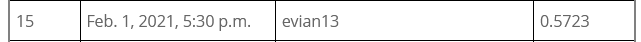

## Step 2 : Advanced Feature engineering


### Task 1 : Loading libraries and dataset

In [161]:
%reset -f

In [162]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
import xgboost
from sklearn.model_selection import train_test_split
import delayed
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score 
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.datasets import make_moons
from sklearn.model_selection import RandomizedSearchCV
import math
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
import sys
from numpy import mean
import pickle


In [165]:
data_dir  = "/content/drive/MyDrive/U4_Prediction_stock_auction_volumes/dataset"
data_list = glob.glob(os.path.join(data_dir, '**.csv'))

In [166]:
y_train = pd.read_csv("%s/y_train.csv" % data_dir, sep=",")
x_train = pd.read_csv("%s/x_train.csv" % data_dir, sep=",")
x_test=pd.read_csv("%s/x_test.csv" % data_dir, sep=",")

### Task 2 : Missing values

#### 2.1 Identify missing values

In [167]:
all_features = list(x_train.columns) 

In [168]:
columns_with_missing_values = x_train.columns[x_train.isnull().any()]
x_train[columns_with_missing_values].isnull().sum()

abs_ret0      4996
abs_ret1     27779
abs_ret2     26892
abs_ret3     21945
abs_ret4     23514
             ...  
rel_vol56    32030
rel_vol57    31882
rel_vol58    31479
rel_vol59    30558
rel_vol60    29959
Length: 122, dtype: int64

In [169]:
return_cols = [c for c in x_train.columns if c.startswith("abs_ret")]
volume_cols = [c for c in x_train.columns if c.startswith("rel_vol")]
target_exp_col = ["target_exp"]
date_col = ["day"]
prod_id_col=["pid"]
other_cols = ["LS" , "NLV"]

In [170]:
#sum of nans
for df in [x_train,x_test]:
    df["return_nan"] = df[return_cols].isnull().sum(axis=1)

#### 2.2 Replace nanas by interpolation

In [171]:
#replace nans by interpolation
for df in [x_train,x_test]:
    for x in [return_cols,volume_cols]:
        df[x] = df[x].interpolate(axis=1, limit_direction="both", inplace=False)

In [172]:
del df

### Task 3 : Feature Engineering



#### 3.1 Merge and transform target to exp()

In [173]:
x_train = y_train.merge(x_train, on="ID")

In [174]:
x_train["is_train"] = True
x_test["is_train"] = False
x_test["target"] = None

In [175]:
all_data = pd.concat([x_train, x_test])

In [176]:
all_data['target_exp'] = all_data['target'].apply(lambda x : math.exp(x))

#### 3.2 Add median, std, avg for each period of volume and ret

In [177]:
def get_stats_groupby(all_data, groupby_cols):
    for groupby_obj in groupby_cols:
        groupby_col = groupby_obj["id"]
        #print(groupby_col)
        cols = groupby_obj["cols"]
        group_by = all_data.groupby([groupby_col])
        #print(group_by)
        data_arr = []
        data_arr.append({"i": "avg", "d": group_by[cols].mean()})
        #data_arr.append({"i": "skew", "d": group_by[cols].skew()})
        #data_arr.append({"i": "kurt", "d": group_by[cols].apply(pd.DataFrame.kurt)})
        data_arr.append({"i": "std", "d": group_by[cols].std()})
        data_arr.append({"i": "median", "d": group_by[cols].median()})
        #data_arr.append({"i": "nan", "d": all_data.isnull().groupby(all_data[groupby_col])[cols].sum()})
        #print(data_arr)
        all_data_stats = all_data.copy()
        all_data_stats.set_index([groupby_col], inplace=True)
        for obj_data in data_arr:
            names = ['%s_%s_%s' % (obj_data["i"], groupby_col, col) for col in cols]            
            all_data_stats[names] = (obj_data["d"]).astype("float32")
        all_data_stats.reset_index(inplace=True)
    return all_data_stats

In [178]:
#group by day to get more features
calculation_group_by =[
    {"id":"day",
     "cols": volume_cols + return_cols,
    }
]

In [179]:
all_data_stats = get_stats_groupby(all_data, calculation_group_by)

#### 3.3 Add median, std, avg for each period of target

In order to identify later the "special days" of high fixing volume

In [180]:
def get_target_groupby(all_data, groupby_cols):
    for groupby_obj in groupby_cols:
        groupby_col = groupby_obj["id"]
        #print(groupby_col)
        cols = groupby_obj["cols"]
        group_by = all_data.groupby([groupby_col])
        #print(group_by)
        data_arr = []
        data_arr.append({"i": "avg", "d": group_by[cols].mean()})
        #data_arr.append({"i": "skew", "d": group_by[cols].skew()})
        #data_arr.append({"i": "kurt", "d": group_by[cols].apply(pd.DataFrame.kurt)})
        data_arr.append({"i": "std", "d": group_by[cols].std()})
        data_arr.append({"i": "median", "d": group_by[cols].median()})
        data_arr.append({"i": "sum", "d": group_by[cols].sum()})
        #data_arr.append({"i": "min", "d": group_by[cols].min()})
        #data_arr.append({"i": "max", "d": group_by[cols].max()})
        #data_arr.append({"i": "nan", "d": all_data.isnull().groupby(all_data[groupby_col])[cols].sum()})
        #print(data_arr)
        all_data_stats = all_data.copy()
        all_data_stats.set_index([groupby_col], inplace=True)
        for obj_data in data_arr:
            names = ['%s_%s_%s' % (obj_data["i"], groupby_col, col) for col in cols]            
            all_data_stats[names] = (obj_data["d"]).astype("float32")
        all_data_stats.reset_index(inplace=True)
    return all_data_stats

In [181]:
target_group_by =[
    {"id":"day",
     "cols": ["target_exp"],
    }
]

In [182]:
all_data_stats = get_target_groupby(all_data_stats, target_group_by)

#### 3.4 Add basic feature for each day and each pid

In [183]:
all_data_stats['min_ret']    = np.min(all_data_stats.iloc[:,4:64], axis=1)
all_data_stats['max_ret']    = np.max(all_data_stats.iloc[:,4:64], axis=1)
all_data_stats['std_ret']    = np.std(all_data_stats.iloc[:,4:64], axis=1)
all_data_stats['median_ret'] = np.median(all_data_stats.iloc[:,4:64], axis=1)
all_data_stats['sum_ret']    = np.sum(all_data_stats.iloc[:,4:64], axis=1)

In [184]:
all_data_stats['min_vol']    = np.min(all_data_stats.iloc[:,65:126], axis=1)
all_data_stats['max_vol']    = np.max(all_data_stats.iloc[:,65:126], axis=1)
all_data_stats['std_vol']    = np.std(all_data_stats.iloc[:,65:126], axis=1)
all_data_stats['median_vol'] = np.median(all_data_stats.iloc[:,65:126], axis=1)

#### 3.5 Add median by day of sum ret 

In [185]:
def get_groupby_med(all_data, groupby_cols):
    for groupby_obj in groupby_cols:
        groupby_col = groupby_obj["id"]
        #print(groupby_col)
        cols = groupby_obj["cols"]
        group_by = all_data.groupby([groupby_col])
        #print(group_by)
        data_arr = []
        data_arr.append({"i": "median", "d": group_by[cols].median()})
        #data_arr.append({"i": "nan", "d": all_data.isnull().groupby(all_data[groupby_col])[cols].sum()})
        #print(data_arr)
        all_data_stats = all_data.copy()
        all_data_stats.set_index([groupby_col], inplace=True)
        for obj_data in data_arr:
            names = ['%s_%s_%s' % (obj_data["i"], groupby_col, col) for col in cols]            
            all_data_stats[names] = (obj_data["d"]).astype("float32")
        all_data_stats.reset_index(inplace=True)
    return all_data_stats

In [186]:
dic_med =[
    {"id":"day",
     "cols": ["sum_ret"],
    }
]

In [187]:
all_data_stats = get_groupby_med(all_data_stats, dic_med)

#### 3.6 Add median sum ret before






Before : getting daily variation of ret

In [188]:
target_analysis = all_data_stats[['day','median_day_sum_ret']]

In [189]:
target_analysis=target_analysis.sort_values(by='day').groupby(by='day').mean()

In [190]:
target_analysis['median_day_sum_ret_before'] = None
for i in target_analysis.index: 
  if i == 0:
    target_analysis['median_day_sum_ret_before'][i] = 0
  else:
    target_analysis['median_day_sum_ret_before'][i] = (target_analysis['median_day_sum_ret'][i]-target_analysis['median_day_sum_ret'][j])/target_analysis['median_day_sum_ret'][j]
  j = i 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [191]:
target_analysis['day']=target_analysis.index

In [192]:
target_analysis.index.name=''

In [193]:
target_analysis 

,median_day_sum_ret,median_day_sum_ret_before,day
,,,
0,1.120654,0,0
1,1.019131,-0.0905932,1
2,0.902086,-0.114848,2
3,1.168097,0.294885,3
4,0.988616,-0.153652,4
...,...,...,...
1147,13.301187,0.0125656,1147
1148,17.758280,0.33509,1148
1149,12.368063,-0.303533,1149


In [194]:
(target_analysis.sort_values(by = 'median_day_sum_ret_before', ascending=False)[['day','median_day_sum_ret_before']].head(n =12)).sort_values(by = 'day')

,day,median_day_sum_ret_before
,,
23,23,1.21533
53,53,0.590906
64,64,0.59866
81,81,5.11149
126,126,0.609638
148,148,0.488069
309,309,1.07988
399,399,0.629169
519,519,0.599741


#### 3.7 Add clustering of sum ret before

K_means according to the sign of 'median_day_sum_ret_before'

In [195]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(target_analysis['median_day_sum_ret_before'].values.reshape(-1, 1))

In [196]:
target_analysis['kmeans_cluster_median_day_sum_ret_before'] = kmeans.labels_

In [197]:
target_analysis

,median_day_sum_ret,median_day_sum_ret_before,day,kmeans_cluster_median_day_sum_ret_before
,,,,
0,1.120654,0,0,0
1,1.019131,-0.0905932,1,4
2,0.902086,-0.114848,2,4
3,1.168097,0.294885,3,1
4,0.988616,-0.153652,4,4
...,...,...,...,...
1147,13.301187,0.0125656,1147,0
1148,17.758280,0.33509,1148,1
1149,12.368063,-0.303533,1149,4


K_means absolute value of 'median_day_sum_ret_before'

In [198]:
kmeans_abs = KMeans(n_clusters=3, random_state=0).fit(abs(target_analysis['median_day_sum_ret_before'].values).reshape(-1, 1))

In [199]:
target_analysis['abs_kmeans_cluster_median_day_sum_ret_before'] = kmeans_abs.labels_

In [200]:
target_analysis

,median_day_sum_ret,median_day_sum_ret_before,day,kmeans_cluster_median_day_sum_ret_before,abs_kmeans_cluster_median_day_sum_ret_before
,,,,,
0,1.120654,0,0,0,2
1,1.019131,-0.0905932,1,4,2
2,0.902086,-0.114848,2,4,2
3,1.168097,0.294885,3,1,0
4,0.988616,-0.153652,4,4,2
...,...,...,...,...,...
1147,13.301187,0.0125656,1147,0,2
1148,17.758280,0.33509,1148,1,0
1149,12.368063,-0.303533,1149,4,0


In [201]:
all_data_stats = all_data_stats.merge(target_analysis[['day','median_day_sum_ret_before','kmeans_cluster_median_day_sum_ret_before','abs_kmeans_cluster_median_day_sum_ret_before']], how="inner",on="day")
del target_analysis

### Task 4 : Machine learning for feature creation

#### 4.1 Create train, test dataset

In [202]:
train_dataset = all_data_stats[all_data_stats['day']<805]
test_dataset = all_data_stats[all_data_stats['day']>=805]

#### 4.2 Create target dummy variable

In [203]:
train_dataset['median_target_dummy'] = (train_dataset['median_day_target_exp'] >0.52).astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [204]:
return_cols = [c for c in train_dataset.columns if c.startswith("abs_ret")]
volume_cols = [c for c in train_dataset.columns if c.startswith("rel_vol")]
all_cols = [c for c in train_dataset.columns if not (c.endswith("day_target_exp") or (c =='median_day_target_dummy')  or (c == 'target') or (c== 'target_exp') or (c=='is_train'))]
date_col = ["day"]
prod_id_col=["pid"]
other_cols = ["LS" , "NLV"]

In [205]:
test_dataset= test_dataset[test_dataset.columns & all_cols]

In [206]:
train_dataset = train_dataset[train_dataset.columns & all_cols]

In [207]:
train_dataset['pid']=train_dataset['pid'].astype('category')
test_dataset['pid']=test_dataset['pid'].astype('category')

train_dataset['median_target_dummy']=train_dataset['median_target_dummy'].astype('category')


train_dataset['ID']=train_dataset['ID'].astype('category')
test_dataset['ID']= test_dataset['ID'].astype('category')

In [208]:
features = [c for c in train_dataset.columns if not (c.endswith("median_target_dummy"))]
label = ["median_target_dummy"]

In [209]:
X_classif = train_dataset[features]

In [210]:
y_classif = train_dataset[label]

#### 4.3 Machine learning feature creation


In [211]:
def evaluate_clf(clf, features, labels, num_iters=10, test_size=0.3):
    print (clf)
    accuracy = []
    precision = []
    recall = []
    first = True
    for trial in range(num_iters):
        features_train, features_test, labels_train, labels_test =\
            train_test_split(features, labels, test_size=test_size)
        clf.fit(features_train,labels_train)
        predictions = clf.predict(features_test)
        accuracy.append(accuracy_score(labels_test, predictions))
        precision.append(precision_score(labels_test, predictions))
        recall.append(recall_score(labels_test, predictions))
        if trial % 10 == 0:
            if first:
                sys.stdout.write('\nProcessing')
            sys.stdout.write('.')
            sys.stdout.flush()
            first = False

    print ("done.\n")
    print ("precision: {}".format(mean(precision)))
    print ("recall:    {}".format(mean(recall)))
    print ("accuracy:    {}".format(mean(accuracy)))
    return len(labels_test)
    return mean(precision), mean(recall)

In [212]:
tre_clf=DecisionTreeClassifier(random_state=42)

In [ ]:
#evaluate_clf(tre_clf, X_classif,y_classif['median_target_dummy'])

precision: 1.0
recall:    1.0
accuracy:    1.0

205345

#### 4.4 fit the model with train dataset

In [ ]:
tre_clf.fit(X_classif,y_classif['median_target_dummy'])


In [ ]:
# save the classifier
#with open('/content/drive/MyDrive/M2/U4_Prediction_stock_auction_volumes/notebook/rf_classifier.pkl', 'wb') as fid:
    #pickle.dump(tre_clf, fid)    

In [ ]:
# load it again
with open('/content/drive/MyDrive/M2/U4_Prediction_stock_auction_volumes/notebook/rf_classifier.pkl', 'rb') as fid:
    tre_clf = pickle.load(fid)

#### 4.5 Predict the dummy target variable on test

In [ ]:
test_dataset['median_target_dummy'] = tre_clf.predict(test_dataset)

### Task 5 : Create final dataset from Advanced FE

In [ ]:
data_dir  = "/content/drive/MyDrive/M2/U4_Prediction_stock_auction_volumes/dataset"
data_list = glob.glob(os.path.join(data_dir, '**.csv'))

In [ ]:
y_train = pd.read_csv("%s/y_train.csv" % data_dir, sep=",")

In [ ]:
train_dataset

In [ ]:
train_dataset=train_dataset.merge(y_train, on="ID")

In [ ]:
del y_train

In [ ]:
train_dataset.to_csv('/content/drive/MyDrive/M2/U4_Prediction_stock_auction_volumes/dataset/clean_dataset/train_dataset.csv',sep=',', index=False)
test_dataset.to_csv('/content/drive/MyDrive/M2/U4_Prediction_stock_auction_volumes/dataset/clean_dataset/test_dataset.csv',sep=',', index=False)

## Step 3 : Machine Learning modeling

### Task 1 Loading libraries and dataset

#### 1.1 Lib and dataset

In [213]:
%reset -f

In [214]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
import xgboost
from sklearn.model_selection import train_test_split
import delayed
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score 
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.datasets import make_moons
from sklearn.model_selection import RandomizedSearchCV
import math
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
import sys
from numpy import mean
import pickle
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble  import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import preprocessing

from sklearn.metrics import mean_squared_error


In [ ]:
"""!rm -r /content/LightGBM
!git clone --recursive https://github.com/Microsoft/LightGBM
%cd /content/LightGBM
!mkdir build
!cmake -DUSE_GPU=1 #avoid ..
!make -j$(nproc)
!sudo apt-get -y install python-pip
!sudo -H pip install setuptools pandas numpy scipy scikit-learn -U
%cd /content/LightGBM/python-package
!sudo python setup.py install --precompile"""

'!rm -r /content/LightGBM\n!git clone --recursive https://github.com/Microsoft/LightGBM\n%cd /content/LightGBM\n!mkdir build\n!cmake -DUSE_GPU=1 #avoid ..\n!make -j$(nproc)\n!sudo apt-get -y install python-pip\n!sudo -H pip install setuptools pandas numpy scipy scikit-learn -U\n%cd /content/LightGBM/python-package\n!sudo python setup.py install --precompile'

In [215]:
data_dir  = "/content/drive/MyDrive/U4_Prediction_stock_auction_volumes/dataset/clean_dataset"
data_list = glob.glob(os.path.join(data_dir, '**.csv'))

In [216]:
train_dataset = pd.read_csv("%s/train_dataset.csv" % data_dir, sep=",")
test_dataset = pd.read_csv("%s/test_dataset.csv" % data_dir, sep=",")

#### 1.2 Store ID 

We don't need ID in ML model

In [217]:
ID_train=train_dataset['ID']
ID_test=test_dataset['ID']

In [218]:
train_dataset=train_dataset.drop("ID",axis=1)
test_dataset=test_dataset.drop("ID",axis=1)

#### 1.3 Categorical encoding

In [219]:
train_dataset['pid']=train_dataset['pid'].astype('category')
train_dataset['median_target_dummy']=train_dataset['median_target_dummy'].astype('category')

In [220]:
test_dataset['pid']=test_dataset['pid'].astype('category')
test_dataset['median_target_dummy']=test_dataset['median_target_dummy'].astype('category')

In [221]:
cat_features=["pid","median_target_dummy"]

In [ ]:
#train_dataset=pd.get_dummies(train_dataset,columns=['pid','median_target_dummy'])
#test_dataset=pd.get_dummies(test_dataset,columns=['pid','median_target_dummy'])


#### 1.4 Store target and pid

In [222]:
y_train = train_dataset[['pid','target']]
train_dataset = train_dataset.drop(columns = ['target'])

### Task 2 : K-best for feature reduction

In [223]:
features = [c for c in train_dataset.columns if c !="target"]
label = ["target"]

In [224]:
def getTopFeatures(train_x, train_y, n_features=15):
    f_val_dict = {}
    p_val_dict = {} 
    f_val, p_val = f_regression(train_x,train_y)
    for i in range(len(f_val)):
        if math.isnan(f_val[i]):
            f_val[i] = 0.0
        f_val_dict[i] = f_val[i]
        if math.isnan(p_val[i]):
            p_val[i] = 0.0
        p_val_dict[i] = p_val[i]
    
    sorted_f = sorted(f_val_dict.items(), key=lambda item: item[1],reverse=True)
    sorted_p = sorted(p_val_dict.items(), key=lambda item: item[1],reverse=True)
    
    feature_indexs = []
    for i in range(0,n_features):
        feature_indexs.append(sorted_f[i][0])
    
    return feature_indexs

In [ ]:
Selected_features = getTopFeatures(train_dataset,y_train['target'])
Selected_features = np.array(Selected_features)

In [ ]:
train_dataset.iloc[:,Selected_features]

,NLV,sum_ret,median_ret,median_target_dummy,std_ret,return_nan,avg_day_rel_vol0,median_day_rel_vol0,std_day_rel_vol0,max_ret,day,max_vol,rel_vol0,abs_ret15,abs_ret9
0,0.646580,0.739680,0.000000,0,0.022135,0,0.049047,0.039607,0.045797,0.102399,0,0.076994,0.017012,0.000000,0.073260
1,0.835479,1.878094,0.000000,0,0.047647,0,0.049047,0.039607,0.045797,0.218818,0,0.135543,0.086902,0.088771,0.110302
2,1.270225,1.492592,0.020502,0,0.028894,0,0.049047,0.039607,0.045797,0.109649,0,0.056237,0.050771,0.000000,0.082079
3,1.288022,1.120654,0.012723,0,0.021687,0,0.049047,0.039607,0.045797,0.102119,0,0.038170,0.033444,0.025569,0.050988
4,0.553135,1.284760,0.021200,0,0.024410,0,0.049047,0.039607,0.045797,0.106270,0,0.082588,0.071315,0.063884,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
684477,-1.292121,16.987811,0.252966,1,0.272910,2,0.045077,0.035815,0.035454,1.434599,770,0.151295,0.019060,0.665004,0.672834
684478,-1.104483,8.717839,0.102250,1,0.143534,5,0.045077,0.035815,0.035454,0.754875,770,0.086605,0.024668,0.040858,0.000000
684479,-1.179556,5.703267,0.000000,1,0.127382,3,0.045077,0.035815,0.035454,0.431034,770,0.098189,0.030452,0.000000,0.428266
684480,-1.370424,8.491105,0.074686,1,0.149656,1,0.045077,0.035815,0.035454,0.601052,770,0.092877,0.045159,0.000000,0.370370


### Task 3 : Evaluate ML models

#### 3.1 Define Ml models

##### 3.1.1 Linear Regression 


In [ ]:
l_reg = LinearRegression()

##### 3.1.2 Random Forest

In [ ]:
rf_reg = RandomForestRegressor(max_depth = 5,max_features = 'sqrt',n_estimators = 10, random_state = 42)

##### 3.1.3 Gradient Boosting Regressor

In [ ]:
gb_reg = GradientBoostingRegressor(random_state = 42)

##### 3.1.4 Decision Tree Regressor

In [ ]:
tre_reg =DecisionTreeRegressor(random_state=42)

##### 3.1.5 KNeighborsRegressor

In [ ]:
knn_clf = KNeighborsRegressor(n_neighbors=3)

#### 3.2 Define Evaluate function

In [ ]:
def evaluate_pred_reg(clf, features, labels, num_iters=5, test_size=0.3):
    print (clf)
    mean_squared_error_score = []
    first = True
    for trial in range(num_iters):
        features_train, features_test, labels_train, labels_test =\
            train_test_split(features, labels, test_size=test_size)
        clf.fit(features_train,labels_train)
        predictions = clf.predict(features_test)
        mean_squared_error_score.append(mean_squared_error(labels_test, predictions))

        if trial % 10 == 0:
            if first:
                sys.stdout.write('\nProcessing')
            sys.stdout.write('.')
            sys.stdout.flush()
            first = False
    #print ("done.\n")
    #print ("mse: {}".format(mean(mean_squared_error_score)))
    return mean(mean_squared_error_score)

#### 3.3 Run evaluate function for ML models

##### 3.3.1 Evaluate linear

In [ ]:
%time
#evaluate_pred_reg(l_reg, train_dataset.iloc[:,Selected_features], y_train['target'])

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs


##### 3.3.2 Random Forest

In [ ]:
#evaluate_pred_reg(rf_reg, train_dataset.iloc[:,Selected_features], y_train['target'])


##### 3.3.3 Evaluate Gradient Boosting

In [ ]:
#evaluate_pred_reg(gb_reg, train_dataset.iloc[:,Selected_features], y_train['target'])

##### 3.3.4 Decision Tree Regressor

In [ ]:
#evaluate_pred_reg(tre_reg, train_dataset.iloc[:,Selected_features], y_train['target'])

##### 3.3.5 Evaluate Knn regressor

In [ ]:
#evaluate_pred_reg(knn_clf,train_dataset.iloc[:,Selected_features],y_train['target'])

### Task 4 : Advanced ML modelling per pid

#### 4.1 Data preperation for advanced ML

Get unique pid

In [ ]:
pid = list(train_dataset['pid'].unique())

In [ ]:
train_dataset_2 = train_dataset

In [ ]:
test_dataset_2 = test_dataset

In [ ]:
features = [c for c in train_dataset.columns if ((c !="target") &(c !="pid") & (c !="day") & (c !="median_target_dummy"))]

#### 4.2 Standard Scaler

In [ ]:
scaler = preprocessing.StandardScaler()
train_dataset_2[features] = scaler.fit_transform(train_dataset_2[features])
test_dataset_2[features]=scaler.fit_transform(test_dataset_2[features])

#### 4.3 Evalute Linear modelling for each pid

In [ ]:
resultat = []
i=0 
for pid_i in pid:
  resultat.append(evaluate_pred_reg(l_reg,train_dataset_2[train_dataset_2['pid']==pid_i].iloc[:,Selected_features], y_train[y_train['pid']==pid_i]['target']))
  print(i)
  i+=1

LinearRegression()

Processing.0
LinearRegression()

Processing.1
LinearRegression()

Processing.2
LinearRegression()

Processing.3
LinearRegression()

Processing.4
LinearRegression()

Processing.5
LinearRegression()

Processing.6
LinearRegression()

Processing.7
LinearRegression()

Processing.8
LinearRegression()

Processing.9
LinearRegression()

Processing.10
LinearRegression()

Processing.11
LinearRegression()

Processing.12
LinearRegression()

Processing.13
LinearRegression()

Processing.14
LinearRegression()

Processing.15
LinearRegression()

Processing.16
LinearRegression()

Processing.17
LinearRegression()

Processing.18
LinearRegression()

Processing.19
LinearRegression()

Processing.20
LinearRegression()

Processing.21
LinearRegression()

Processing.22
LinearRegression()

Processing.23
LinearRegression()

Processing.24
LinearRegression()

Processing.25
LinearRegression()

Processing.26
LinearRegression()

Processing.27
LinearRegression()

Processing.28
LinearRegression()

Proc

In [ ]:
mean(resultat)
#list(train_dataset['pid'].unique())

0.3702027724976742

50 features 0.39
25 features 0.37
20 features 0.37
15 features 0.36
10 features 0.4


In [ ]:
resultat_df = pd.DataFrame(resultat, columns = ['MSE'])
resultat_df['pid'] = pid

In [ ]:
bad_pid = list(resultat_df[resultat_df['MSE']>0.4]['pid'])

In [ ]:
len(bad_pid)

252

#### 4.4 Run linear predict for each pid

In [ ]:
len(test_dataset)

311744

In [ ]:
for pid in list(train_dataset['pid'].unique()):  
  l_reg_2 = LinearRegression()
  l_reg_2.fit(train_dataset_2[train_dataset_2['pid']==pid].iloc[:,Selected_features], y_train[y_train['pid']==pid]['target'])
  y_test = pd.DataFrame(l_reg_2.predict(test_dataset_2[test_dataset_2['pid'] == pid].iloc[:,Selected_features]),columns=['target'])
  y_test = y_test.set_index(test_dataset_2[test_dataset_2['pid'] == pid].index)
  if pid == 360 :
    y_final = y_test
  else :
    y_final = pd.concat([y_final,y_test], axis = 0)
y_final = y_final.sort_index()

### Task 5 : XGboost error prediction

In [ ]:
y_train['day'] = train_dataset['day']

In [ ]:
train_X_error, test_X_error, train_y_error, test_y_error = train_test_split(train_dataset_2, y_train, test_size=0.5, random_state=42)

In [ ]:
date_series = test_X_error['day']

In [ ]:
pid = list(train_X_error['pid'].unique())

In [ ]:
pid[0]

183

In [ ]:
for pid_id in pid:  
  print(pid_id)
  l_reg_error = LinearRegression()
  l_reg_error.fit(train_X_error[train_X_error['pid']==pid_id].iloc[:,Selected_features], train_y_error[train_y_error['pid']==pid_id]['target'])
  y_test_error = pd.DataFrame(l_reg_error.predict(test_X_error[test_X_error['pid'] == pid_id].iloc[:,Selected_features]),columns=['target'])
  y_test_error = y_test_error.set_index(test_X_error[test_X_error['pid'] == pid_id].index)
  if pid_id == pid[0] :
      y_final_error = y_test_error
  else :
      y_final_error = pd.concat([y_final_error,y_test_error], axis = 0)

y_final_error = y_final_error.sort_index()
test_X_error['predict'] = y_final_error


183
420
288
526
584
431
211
128
787
800
115
491
360
591
434
522
164
768
445
320
593
603
667
6
629
781
858
429
862
404
334
465
775
459
387
656
699
126
330
482
821
300
783
275
873
177
72
375
143
241
67
368
351
536
289
344
875
296
762
439
730
118
610
163
601
835
56
333
132
273
356
712
42
23
3
637
337
774
406
525
838
548
841
823
581
19
52
598
469
127
702
283
680
579
569
88
694
11
634
236
716
818
711
641
530
287
870
693
407
811
399
379
502
395
717
578
773
57
473
701
367
252
815
223
695
450
721
291
378
137
709
438
377
276
69
74
604
410
323
87
796
310
597
863
311
322
595
529
107
40
867
644
31
899
883
540
170
845
706
200
85
176
890
263
20
562
192
652
130
561
462
669
51
219
878
585
338
91
369
196
93
519
157
755
664
560
658
346
791
175
227
686
278
99
766
405
847
806
770
8
317
831
454
654
495
757
358
659
626
146
851
778
760
371
734
341
708
17
551
691
138
607
476
398
826
879
233
43
411
190
385
872
259
169
882
214
225
83
160
824
627
340
628
417
537
651
850
180
820
150
231
147
498
141
671
240
545
83

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [ ]:
(mean_squared_error(test_y_error['target'], test_X_error['predict']))

0.3777353663860586

In [ ]:
y_test_error = pd.DataFrame(y_test_error)

In [ ]:
test_X_error['error']=test_y_error["target"] - test_X_error['predict']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
min_date = date_series.min()
max_date = date_series.max()

In [ ]:
dates = list(range(min_date, max_date + 1))
len(dates)

805

In [ ]:
X_error_train = test_X_error[test_X_error['day']<=600].drop(['error'], axis = 1)
y_error_train = test_X_error[test_X_error['day']<=600]['error']

In [ ]:
X_error_test = test_X_error[test_X_error['day']>600].drop(['error'], axis = 1)
y_error_test = test_X_error[test_X_error['day']>600]['error']

In [ ]:
Selected_features2 = [125, 497, 496, 506, 495, 126, 127, 371, 249, 494,   0, 499,  63,
        17,  11,507]

In [ ]:
X_error_train['median_target_dummy'] = X_error_train['median_target_dummy'].astype('int')

In [ ]:
test_X_error.iloc[:,Selected_features2]
test_X_error['error']

99589    -0.236138
535740   -1.854041
228479    2.750132
214338    0.557808
242520    0.979978
            ...   
343544    0.557250
646428    0.265962
142340   -0.130043
143115   -0.377147
446301    0.105719
Name: error, Length: 342241, dtype: float64

In [ ]:
def learning_rate_010_decay_power_099(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_010_decay_power_0995(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_005_decay_power_099(current_iter):
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3



In [ ]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'neg_mean_squared_error', 
            "eval_set" : [(X_error_test.iloc[:,Selected_features2],y_error_test)],
            'eval_names': ['valid'],
            'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100,
            'categorical_feature':'auto'}

In [ ]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [ ]:
model = LGBMRegressor( random_state=314, n_estimators=1000, device='gpu')
tscv = TimeSeriesSplit(n_splits=2)
n_HP_points_to_test = 100

gs = RandomizedSearchCV(
    estimator=model, 
    param_distributions=param_test, 
    n_iter= n_HP_points_to_test,
    scoring= 'neg_mean_squared_error',
    cv= tscv,
    refit=True,
    random_state=314,
    verbose=True)

In [ ]:
#gs.fit(X_error_train.iloc[:,Selected_features2], y_error_train)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

AttributeError: ignored

In [ ]:
opt_parameters = {'colsample_bytree': 0.7076074093370144, 
                  'min_child_samples': 105, 
                  'min_child_weight': 1e-05, 
                  'num_leaves': 26, 
                  'reg_alpha': 5, 
                  'reg_lambda': 5, 
                  'subsample': 0.7468773130235173} 
                  
LGBM_final = LGBMRegressor(**model.get_params())

In [ ]:
evaluate_pred_reg(LGBM_final, test_X_error.iloc[:,Selected_features2], test_X_error['error'])

Add error just for bad predict

In [ ]:
test_dataset_2['predict']  = y_final

In [ ]:
test_dataset_2['median_target_dummy']=test_dataset_2['median_target_dummy'].astype('category')

In [ ]:
test_dataset_2['error'] = LGBM_final.predict(test_dataset_2.iloc[:,Selected_features2])

In [ ]:
pid_test = list(test_dataset_2['pid'].unique())

In [ ]:
i = 0

for pid_id in pid_test:  
  print(i)
  if pid_id == pid_test[0] :
    #if pid_id in bad_pid :
     # y_predict_final = test_dataset_2[test_dataset_2['pid'] == pid_id]['predict'] + test_dataset_2[test_dataset_2['pid'] == pid_id]['error']
    #else :
    y_predict_final= test_dataset_2[test_dataset_2['pid'] == pid_id]['predict']
    y_predict_final['index'] = test_dataset_2[test_dataset_2['pid'] == pid_id].index
  else :
    if pid_id in bad_pid :
      y_predict = test_dataset_2[test_dataset_2['pid'] == pid_id]['predict'] 
      y_predict = y_predict +  test_dataset_2[test_dataset_2['pid'] == pid_id]['error']
    else :
      y_predict = test_dataset_2[test_dataset_2['pid'] == pid_id]['predict']
   
    y_predict['index'] = test_dataset_2[test_dataset_2['pid'] == pid_id].index
    y_predict_final = pd.concat([y_predict_final,y_predict], axis = 0)
  i +=1



### Task 6 : Final Prediction

In [ ]:
predictions

In [ ]:
predictions

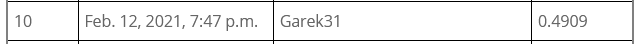

## Step 4 : Deep Learning

### Task 1 Loading libraries and dataset

#### 1.1 Lib and dataset

In [225]:
%reset -f

In [226]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
import xgboost
from sklearn.model_selection import train_test_split
#import delayed
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score 
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.datasets import make_moons
from sklearn.model_selection import RandomizedSearchCV
import math
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
import sys
from numpy import mean
import pickle
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble  import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import preprocessing
from torch.autograd import Variable

import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

from tqdm import tqdm_notebook as tqdm
import joblib

import torch
from torch import nn

from fastprogress import master_bar, progress_bar

import random

ImportError: ignored

In [ ]:
data_dir  = "/content/drive/MyDrive/U4_Prediction_stock_auction_volumes/dataset/clean_dataset"
data_list = glob.glob(os.path.join(data_dir, '**.csv'))

In [ ]:
train_dataset = pd.read_csv("%s/train_dataset.csv" % data_dir, sep=",")
test_dataset = pd.read_csv("%s/test_dataset.csv" % data_dir, sep=",")

In [ ]:
train_dataset.head()

,day,ID,pid,abs_ret0,abs_ret1,abs_ret2,abs_ret3,abs_ret4,abs_ret5,abs_ret6,abs_ret7,abs_ret8,abs_ret9,abs_ret10,abs_ret11,abs_ret12,abs_ret13,abs_ret14,abs_ret15,abs_ret16,abs_ret17,abs_ret18,abs_ret19,abs_ret20,abs_ret21,abs_ret22,abs_ret23,abs_ret24,abs_ret25,abs_ret26,abs_ret27,abs_ret28,abs_ret29,abs_ret30,abs_ret31,abs_ret32,abs_ret33,abs_ret34,abs_ret35,abs_ret36,...,median_day_abs_ret36,median_day_abs_ret37,median_day_abs_ret38,median_day_abs_ret39,median_day_abs_ret40,median_day_abs_ret41,median_day_abs_ret42,median_day_abs_ret43,median_day_abs_ret44,median_day_abs_ret45,median_day_abs_ret46,median_day_abs_ret47,median_day_abs_ret48,median_day_abs_ret49,median_day_abs_ret50,median_day_abs_ret51,median_day_abs_ret52,median_day_abs_ret53,median_day_abs_ret54,median_day_abs_ret55,median_day_abs_ret56,median_day_abs_ret57,median_day_abs_ret58,median_day_abs_ret59,median_day_abs_ret60,min_ret,max_ret,std_ret,median_ret,sum_ret,min_vol,max_vol,std_vol,median_vol,median_day_sum_ret,median_day_sum_ret_before,kmeans_cluster_median_day_sum_ret_before,abs_kmeans_cluster_median_day_sum_ret_before,median_target_dummy,target
0,0,148,360,0.000000,0.000000,0.000000,0.000000,0.029317,0.000000,0.000000,0.000000,0.000000,0.073260,0.073265,0.000000,0.036601,0.102399,0.029261,0.000000,0.073206,0.032942,0.036609,0.000000,0.014641,0.036643,0.000000,0.036630,0.007326,0.000000,0.000000,0.000000,0.000000,0.000000,0.014656,0.0,0.000000,0.000000,0.0,0.021989,0.036627,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.102399,0.022135,0.000000,0.739680,0.001629,0.076994,0.014242,0.011438,1.120654,0.0,0,0,0,-3.403606
1,0,444,203,0.176289,0.000000,0.087951,0.000000,0.044033,0.000000,0.000000,0.218818,0.000000,0.110302,0.088496,0.044307,0.154902,0.000000,0.000000,0.088771,0.000000,0.044307,0.000000,0.000000,0.066622,0.000000,0.044405,0.088692,0.000000,0.000000,0.000000,0.000000,0.000000,0.044287,0.022139,0.0,0.066357,0.066372,0.0,0.066386,0.088633,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.218818,0.047647,0.000000,1.878094,0.001803,0.135543,0.022036,0.009472,1.120654,0.0,0,0,0,-2.193810
2,0,592,398,0.000000,0.027337,0.109649,0.027345,0.027255,0.054675,0.054585,0.000000,0.027307,0.082079,0.027375,0.054675,0.082147,0.041051,0.054780,0.000000,0.082102,0.000000,0.027322,0.027360,0.000000,0.013676,0.000000,0.054750,0.054735,0.027367,0.068428,0.027337,0.013669,0.000000,0.000000,0.0,0.000000,0.054705,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.109649,0.028894,0.020502,1.492592,0.001977,0.056237,0.010132,0.013988,1.120654,0.0,0,0,0,-2.387511
3,0,740,258,0.063403,0.031752,0.006354,0.063573,0.006350,0.076316,0.025436,0.076423,0.000000,0.050988,0.012767,0.038324,0.012765,0.000000,0.012767,0.025569,0.000000,0.025507,0.025523,0.000000,0.012755,0.006383,0.038300,0.102119,0.000000,0.038260,0.025484,0.000000,0.038192,0.000000,0.025468,0.0,0.012731,0.025458,0.0,0.006363,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.102119,0.021687,0.012723,1.120654,0.006477,0.038170,0.006395,0.015730,1.120654,0.0,0,0,0,-2.467485
4,0,888,444,0.063318,0.000000,0.042230,0.021155,0.063532,0.106270,0.042535,0.063939,0.063735,0.000000,0.021268,0.063830,0.021259,0.000000,0.063816,0.063884,0.000000,0.021299,0.021295,0.021254,0.021254,0.000000,0.042526,0.021249,0.000000,0.000000,0.000000,0.000000,0.021245,0.021263,0.000000,0.0,0.042517,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.106270,0.024410,0.021200,1.284760,0.004231,0.082588,0.013899,0.012186,1.120654,0.0,0,0,0,-2.380318


#### 1.2 Store ID 

We don't need ID in ML model

In [ ]:
ID_train=train_dataset['ID']
ID_test=test_dataset['ID']

In [ ]:
train_dataset=train_dataset.drop("ID",axis=1)
test_dataset=test_dataset.drop("ID",axis=1)

#### 1.4 Store target and pid

In [ ]:
y_train = train_dataset[['pid','target']]

### Task 2. LTSM Seq2Seq with Pytorch

#### Standard Scaler

In [ ]:
#features = [c for c in train_dataset.columns if ((c !="target") &(c !="pid") & (c !="day") & (c !="median_target_dummy"))]

In [ ]:
#scaler = preprocessing.StandardScaler()
#train_dataset[features] = scaler.fit_transform(train_dataset[features])

In [ ]:
#test_dataset[features]=scaler.fit_transform(test_dataset[features])

#### Min Max Scaler

In [ ]:
features = [c for c in train_dataset.columns if ((c !="target") & (c !="pid") & (c !="day") & (c !="median_target_dummy"))]

In [ ]:
x_scaler = preprocessing.MinMaxScaler((-1,1))
train_dataset[features] = x_scaler.fit_transform(train_dataset[features])

In [ ]:
target = [c for c in train_dataset.columns if (c =="target")]

In [ ]:
y_scaler = preprocessing.MinMaxScaler((-1,1))
train_dataset['target'] = y_scaler.fit_transform(train_dataset[target])

In [ ]:
#test_dataset['target']=0

In [ ]:
test_dataset[features]=x_scaler.fit_transform(test_dataset[features])

In [ ]:
#test_dataset[target]=y_scaler.fit_transform(test_dataset[target])

##### Pid selection before stacking

In [ ]:
pid_selection = pd.DataFrame(train_dataset['pid'].value_counts()).sort_values(by=['pid'], ascending=False)

In [ ]:
346+10

356

In [ ]:
pid_selection=list(pid_selection[pid_selection['pid']>790].index)

In [ ]:
(pid_selection)

[214,
 663,
 291,
 612,
 710,
 230,
 542,
 450,
 763,
 9,
 452,
 195,
 473,
 722,
 716,
 718,
 712,
 756,
 462,
 471,
 496,
 499,
 703,
 487,
 603,
 93,
 616,
 872,
 96,
 97,
 304,
 357,
 610,
 308,
 309,
 695,
 333,
 541,
 500,
 216,
 25,
 244,
 810,
 1,
 255,
 260,
 204,
 478,
 258,
 227,
 738,
 514,
 505,
 2,
 513,
 14,
 551,
 259,
 431,
 44,
 209,
 771,
 202,
 562,
 468,
 17,
 734,
 501,
 777,
 775,
 512,
 265,
 48,
 425,
 776,
 264,
 876,
 203,
 89,
 588,
 591,
 792,
 66,
 413,
 59,
 412,
 269,
 693,
 270,
 181,
 180,
 783,
 405,
 572,
 789,
 589,
 378,
 177,
 585,
 369,
 54,
 893,
 386,
 68,
 793,
 581,
 895,
 794,
 183,
 795,
 381,
 565,
 584,
 73,
 573,
 796,
 688,
 627,
 126,
 850,
 836,
 225,
 839,
 336,
 843,
 348,
 349,
 778,
 874,
 676,
 804,
 574,
 293,
 618,
 846,
 323,
 340,
 395,
 788,
 65,
 289,
 883,
 290,
 736,
 345,
 344,
 832,
 624,
 321,
 107,
 834,
 443,
 416,
 410,
 434,
 400,
 558,
 50,
 561,
 406,
 569,
 64,
 402,
 549,
 37,
 63,
 576,
 383,
 393,
 394,
 446,

#### Function all pid

In [ ]:
SEED = 42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(SEED)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
###  This function creates a sliding window or sequences of seq_length days and labels_length  days label ####
def sliding_windows(data, seq_length,labels_length):
    x = []
    y = []
    z = []

    for i in range(len(data)-(seq_length+labels_length)):
        _x = data.iloc[i:(i+seq_length),:]
        _y = data.iloc[(i+seq_length):(i+seq_length+labels_length),506:507]
        _z  = data.iloc[(i+seq_length):(i+seq_length+labels_length),:506]
        x.append(np.array(_x))
        y.append(np.array(_y))
        z.append(np.array(_z))

    return x,y,z

In [ ]:
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim,  embedding_dim
        self.num_layers = 3
        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=3,
          batch_first=True,
          dropout = 0.35
        )
   
    def forward(self, x):
       
        x = x.reshape((1, self.seq_len, self.n_features))
        
        h_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_dim).to(device))
         
        
        c_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_dim).to(device))
              
        x, (hidden, cell) = self.rnn1(x,(h_1, c_1))
        
        
        #return hidden_n.reshape((self.n_features, self.embedding_dim))
        return hidden , cell 

In [ ]:
class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()

        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features =  input_dim, n_features
        
        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=input_dim,
          num_layers=3,
          batch_first=True,
          dropout = 0.35
        )
        
        
      
        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x,input_hidden,input_cell):
       
       
        x = x.reshape((1,1,self.n_features ))
        #print("decode input",x.size())
             

        x, (hidden_n, cell_n) = self.rnn1(x,(input_hidden,input_cell))
    
        x = self.output_layer(x)
        return x, hidden_n, cell_n

In [ ]:
class Seq2Seq(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64,output_length = 0):
        super(Seq2Seq, self).__init__()

        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.n_features = n_features
        self.output_length = output_length
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
        

    def forward(self,x, prev_y,features):
        
       
        hidden,cell = self.encoder(x)
         
        #Prepare place holder for decoder output
        targets_ta = []
        #prev_output become the next input to the LSTM cell
        dec_input = prev_y
        
        
        
       #dec_input = torch.cat([prev_output, curr_features], dim=1) 
        
        #itearate over LSTM - according to the required output days
        for out_days in range(self.output_length) :
            
          
            prev_x,prev_hidden,prev_cell = self.decoder(dec_input,hidden,cell)
            hidden,cell = prev_hidden,prev_cell
            
            prev_x = prev_x[:,:,0:1]
            #print("preve x shape is:",prev_x.size())
            #print("features shape is:",features[out_days+1].size())
            
            if out_days+1 < self.output_length :
                dec_input = torch.cat([prev_x,features[out_days+1].reshape(1,1,506)], dim=2) 
            
            targets_ta.append(prev_x.reshape(1))
           
            
        
        
        targets = torch.stack(targets_ta)

        return targets

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

In [ ]:
def train_model(model, TrainX,Trainy,ValidX,Validy, Valid_features, seq_length, n_epochs, train_features, optimizer, criterion, scheduler):
 
    history = dict(train=[], val=[])

    #best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
    mb = master_bar(range(1, n_epochs + 1))

    for epoch in mb:
        model = model.train()

        train_losses = []
        for i in progress_bar(range(TrainX.size()[0]),parent=mb):
            seq_inp = TrainX[i,:,:].to(device)
            seq_true = Trainy[i,:,:].to(device)
            features = train_features[i,:,:].to(device)
           
            optimizer.zero_grad()

            
            seq_pred = model(seq_inp,seq_inp[seq_length-1:seq_length,:],features)
            
            loss = criterion(seq_pred, seq_true)
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()

            train_losses.append(loss.item())

        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for i in progress_bar(range(ValidX.size()[0]),parent=mb):
                seq_inp = ValidX[i,:,:].to(device)
                seq_true = Validy[i,:,:].to(device)
                features = Valid_features[i,:,:].to(device)
        
                seq_pred = model(seq_inp,seq_inp[seq_length-1:seq_length,:],features)
               
                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), 'best_model_n_features.pt')
            print("saved best model epoch:",epoch,"val loss is:",val_loss)

        
        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
        scheduler.step(val_loss)
    #model.load_state_dict(best_model_wts)
    return model.eval(), history

In [ ]:
def seq2seq_global(pid,seq_length,epoch):
  test_pid=test_dataset[test_dataset['pid']==pid]
  test_pid["target"]=None
  train_pid = train_dataset[train_dataset['pid'] == pid]
  all_pid=pd.concat([train_pid,test_pid])

  print(len (all_pid))
  if (len(all_pid)==0):
    return ('No value for this pid')
  all_pid = all_pid.set_index(['day'])

  train_size = int((all_pid.shape[0]-len(test_pid)) * 0.55)
  valid_size = (all_pid.shape[0]-len(test_pid))- train_size
  print("train size is:",train_size)
  print("validation size is:",valid_size)

  train_data = all_pid.iloc[0:train_size,:]
  valid_data = all_pid.iloc[train_size:train_size+valid_size,:]
  print("train data shape is:",train_data.shape)
  print("validation data shape is:",valid_data.shape)

  labels_length = len(test_pid)

  train_X, train_y,train_features = sliding_windows(train_data, seq_length,labels_length)
  print("train X  has:", len(train_X) , "series")
  print("train labels  has:", len(train_y) , "series")
  valid_X, valid_y,valid_features = sliding_windows(valid_data, seq_length,labels_length)

  if (len(valid_X)==0):
    return ('no validation dataset for this pid')
  print("validiation  X  has:", len(valid_X) , "series")
  print("Validiation  labels  has:" ,len(valid_y) , "series")

  trainX = Variable(torch.Tensor(train_X))
  trainy = Variable(torch.Tensor(train_y))
  train_features = Variable(torch.Tensor(train_features))
  validX = Variable(torch.Tensor(valid_X))
  validy= Variable(torch.Tensor(valid_y))
  valid_features = Variable(torch.Tensor(valid_features))
  print ("trainX shape is:",trainX.size())
  print ("trainy shape is:",trainy.size())
  print ("train features  shape is:",train_features.size())
  print ("validX shape is:",validX.size())
  print ("validy shape is:",validy.size())
  print ("valid features  shape is:",valid_features.size())
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  n_features = trainX.shape[2]
  model = Seq2Seq(seq_length, n_features, 512,output_length=len(test_pid))
  model = model.to(device)
  model
  print(model) 
  model.apply(init_weights)
    
  #optimizer = torch.optim.RMSprop(model.parameters())
  #optimizer = torch.optim.Adam(model.parameters(), lr=4e-3,weight_decay=1e-5)
  #optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  criterion = torch.nn.MSELoss().to(device) 
  #lambda1 = lambda epoch: 0.65 ** epoch
  #scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
  #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 5e-3, eta_min=1e-8, last_epoch=-1)
  #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=10, factor =0.5 ,min_lr=1e-7, eps=1e-08)
  optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, mode='min', factor=0.7, verbose=True, min_lr=1e-5)
  
  model, history = train_model(
  model = model,
  TrainX = trainX, Trainy = trainy,
  ValidX= validX, Validy = validy,
  Valid_features = valid_features, 
  seq_length = seq_length,
  n_epochs = epoch, 
  train_features = train_features, 
  optimizer = optimizer, 
  criterion = criterion, 
  scheduler= scheduler   
  )

  TestX = np.array(all_pid.iloc[-2*len(test_pid):-len(test_pid),:])
  Testy = np.array(all_pid.iloc[-len(test_pid):,:])

  TestX = Variable(torch.Tensor(TestX))
  Testy = Variable(torch.Tensor(Testy))

  model.eval()
  with torch.no_grad():
    seq_inp = TestX.to(device)
    seq_pred = model(TestX[0:seq_length,:].to(device),seq_inp[seq_length-1:seq_length,:],seq_inp[:,:506])
    #seq_pred = model(TestX[-seq_length:,:].to(device),seq_inp[seq_length-1:seq_length,:],seq_inp[:,:506])

  data_predict = seq_pred.cpu().numpy()
  #labels = Testy
  #data_predict.flatten()
  
  #original_data = all_pid.iloc[-len(test_pid):,:]
  #final = pd.DataFrame(original_data['target'])
  
  pred = data_predict.flatten()
  pred_df = pd.DataFrame(pred)
  pred_df = pred_df.set_index([test_pid.index])
  test_pid['target'] = pred_df
  
  return test_pid 

##### Run predict all pid

In [ ]:
df_princip = pd.DataFrame([])
df_princip = pd.concat([df_princip, df_princip], axis = 0)

In [ ]:
pid_selection[0:3]

[214, 663, 291]

In [ ]:
df_princip = pd.DataFrame([])
for pid in progress_bar(pid_selection[250:300]):
   df_aux = seq2seq_global(pid = pid, seq_length = 10, epoch = 8)
   df_princip = pd.concat([df_princip, df_aux], axis = 0)

df_princip.to_csv('/content/drive/MyDrive/U4_Prediction_stock_auction_volumes/prediction/lstm_pid/250_300.csv', sep=',', index=True)

1147
train size is: 440
validation size is: 361
train data shape is: (440, 507)
validation data shape is: (361, 507)
train X  has: 84 series
train labels  has: 84 series
validiation  X  has: 5 series
Validiation  labels  has: 5 series
trainX shape is: torch.Size([84, 10, 507])
trainy shape is: torch.Size([84, 346, 1])
train features  shape is: torch.Size([84, 346, 506])
validX shape is: torch.Size([5, 10, 507])
validy shape is: torch.Size([5, 346, 1])
valid features  shape is: torch.Size([5, 346, 506])
Seq2Seq(
  (encoder): Encoder(
    (rnn1): LSTM(507, 512, num_layers=3, batch_first=True, dropout=0.35)
  )
  (decoder): Decoder(
    (rnn1): LSTM(507, 512, num_layers=3, batch_first=True, dropout=0.35)
    (output_layer): Linear(in_features=512, out_features=507, bias=True)
  )
)


saved best model epoch: 1 val loss is: 0.028080455586314203
Epoch 1: train loss 0.019764571494999387 val loss 0.028080455586314203
Epoch 2: train loss 0.01706123480661994 val loss 0.029568711668252944
saved best model epoch: 3 val loss is: 0.02789255976676941
Epoch 3: train loss 0.016911968322736875 val loss 0.02789255976676941
saved best model epoch: 4 val loss is: 0.02671697363257408
Epoch 4: train loss 0.016716912876637208 val loss 0.02671697363257408
saved best model epoch: 5 val loss is: 0.026326731592416764
Epoch 5: train loss 0.01660903383578573 val loss 0.026326731592416764
saved best model epoch: 6 val loss is: 0.026260706409811974
Epoch 6: train loss 0.016468249394425323 val loss 0.026260706409811974
saved best model epoch: 7 val loss is: 0.023813247680664062
Epoch 7: train loss 0.016216207983060962 val loss 0.023813247680664062
saved best model epoch: 8 val loss is: 0.02143314518034458
Epoch 8: train loss 0.015836964050928753 val loss 0.02143314518034458
1147
train size is: 

saved best model epoch: 1 val loss is: 0.011327947489917278
Epoch 1: train loss 0.012214347631448791 val loss 0.011327947489917278
Epoch 2: train loss 0.00810855800574202 val loss 0.011970473080873489
Epoch 3: train loss 0.007856647350958415 val loss 0.01162523590028286
Epoch 4: train loss 0.007718614873565024 val loss 0.01171762365847826
Epoch 5: train loss 0.007589248801758956 val loss 0.01197731588035822
saved best model epoch: 6 val loss is: 0.010991557873785496
Epoch 6: train loss 0.007444710864330686 val loss 0.010991557873785496
Epoch 7: train loss 0.00750346757316341 val loss 0.011635248921811581
Epoch 8: train loss 0.007314317427309496 val loss 0.011668768711388111
1147
train size is: 440
validation size is: 361
train data shape is: (440, 507)
validation data shape is: (361, 507)
train X  has: 84 series
train labels  has: 84 series
validiation  X  has: 5 series
Validiation  labels  has: 5 series
trainX shape is: torch.Size([84, 10, 507])
trainy shape is: torch.Size([84, 346, 1

saved best model epoch: 1 val loss is: 0.013277865014970303
Epoch 1: train loss 0.015245014014432118 val loss 0.013277865014970303
Epoch 2: train loss 0.010211751918264088 val loss 0.013313020020723343
Epoch 3: train loss 0.009644249620448266 val loss 0.013592981919646262
Epoch 4: train loss 0.009349611654345478 val loss 0.014355033449828625
Epoch 5: train loss 0.009122669996161546 val loss 0.013327371887862682
Epoch 6: train loss 0.008935393710132866 val loss 0.014136564731597901
Epoch 7: train loss 0.008637360934655936 val loss 0.013432040996849536
Epoch     7: reducing learning rate of group 0 to 7.0000e-05.
Epoch 8: train loss 0.008405601766536989 val loss 0.014005350694060326
1147
train size is: 440
validation size is: 361
train data shape is: (440, 507)
validation data shape is: (361, 507)
train X  has: 84 series
train labels  has: 84 series
validiation  X  has: 5 series
Validiation  labels  has: 5 series
trainX shape is: torch.Size([84, 10, 507])
trainy shape is: torch.Size([84,

saved best model epoch: 1 val loss is: 0.017718494683504105
Epoch 1: train loss 0.022278298779080313 val loss 0.017718494683504105
saved best model epoch: 2 val loss is: 0.016651373729109763
Epoch 2: train loss 0.018277325412435902 val loss 0.016651373729109763
saved best model epoch: 3 val loss is: 0.01570676378905773
Epoch 3: train loss 0.0172684896027758 val loss 0.01570676378905773
saved best model epoch: 4 val loss is: 0.015470663458108902
Epoch 4: train loss 0.016454931902920918 val loss 0.015470663458108902
Epoch 5: train loss 0.01571124329763864 val loss 0.019908280670642854
Epoch 6: train loss 0.01504922790142397 val loss 0.016607903689146043
Epoch 7: train loss 0.014018256815948657 val loss 0.019020943343639372
Epoch 8: train loss 0.012982066776159974 val loss 0.018600340560078622
1147
train size is: 440
validation size is: 361
train data shape is: (440, 507)
validation data shape is: (361, 507)
train X  has: 84 series
train labels  has: 84 series
validiation  X  has: 5 serie

saved best model epoch: 1 val loss is: 0.03361293524503708
Epoch 1: train loss 0.01931382039384473 val loss 0.03361293524503708
saved best model epoch: 2 val loss is: 0.02447049580514431
Epoch 2: train loss 0.01651423821403157 val loss 0.02447049580514431
Epoch 3: train loss 0.015647535733435126 val loss 0.025379291176795958
Epoch 4: train loss 0.015109613792793382 val loss 0.03883090317249298
saved best model epoch: 5 val loss is: 0.02348432131111622
Epoch 5: train loss 0.014564823980132738 val loss 0.02348432131111622
Epoch 6: train loss 0.014725842025308382 val loss 0.029959313571453094
Epoch 7: train loss 0.014320628152095847 val loss 0.04060457125306129
Epoch 8: train loss 0.013472325989000854 val loss 0.035287410765886304
1148
train size is: 440
validation size is: 361
train data shape is: (440, 507)
validation data shape is: (361, 507)
train X  has: 83 series
train labels  has: 83 series
validiation  X  has: 4 series
Validiation  labels  has: 4 series
trainX shape is: torch.Size

saved best model epoch: 1 val loss is: 0.019363691098988056
Epoch 1: train loss 0.021374206047460258 val loss 0.019363691098988056
saved best model epoch: 2 val loss is: 0.018128428608179092
Epoch 2: train loss 0.01857131124889276 val loss 0.018128428608179092
saved best model epoch: 3 val loss is: 0.01715635322034359
Epoch 3: train loss 0.01792759861213615 val loss 0.01715635322034359
saved best model epoch: 4 val loss is: 0.017115753144025803
Epoch 4: train loss 0.016913928304720355 val loss 0.017115753144025803
Epoch 5: train loss 0.01639766915959407 val loss 0.017281072214245796
Epoch 6: train loss 0.01567707960325551 val loss 0.017246904782950878
Epoch 7: train loss 0.01575755396386586 val loss 0.02024575136601925
Epoch 8: train loss 0.01492330465600433 val loss 0.01785749662667513
1147
train size is: 440
validation size is: 361
train data shape is: (440, 507)
validation data shape is: (361, 507)
train X  has: 84 series
train labels  has: 84 series
validiation  X  has: 5 series
Va

saved best model epoch: 1 val loss is: 0.017528698593378068
Epoch 1: train loss 0.022876135472740446 val loss 0.017528698593378068
Epoch 2: train loss 0.018139864850257124 val loss 0.017664847895503044
Epoch 3: train loss 0.01765818115589874 val loss 0.01753946878015995
saved best model epoch: 4 val loss is: 0.017473863437771797
Epoch 4: train loss 0.01753288596158936 val loss 0.017473863437771797
saved best model epoch: 5 val loss is: 0.017458992823958398
Epoch 5: train loss 0.017359834341775803 val loss 0.017458992823958398
Epoch 6: train loss 0.01707248156890273 val loss 0.01791900098323822
Epoch 7: train loss 0.016746964837823595 val loss 0.018676574900746347
Epoch 8: train loss 0.01628853477138494 val loss 0.01847469061613083
1148
train size is: 440
validation size is: 361
train data shape is: (440, 507)
validation data shape is: (361, 507)
train X  has: 83 series
train labels  has: 83 series
validiation  X  has: 4 series
Validiation  labels  has: 4 series
trainX shape is: torch.S

saved best model epoch: 1 val loss is: 0.01578306104056537
Epoch 1: train loss 0.01567047446158277 val loss 0.01578306104056537
Epoch 2: train loss 0.012556606611932617 val loss 0.016721712425351143
Epoch 3: train loss 0.012210296107882476 val loss 0.016738916747272015
Epoch 4: train loss 0.012141240412840643 val loss 0.016766623593866825
Epoch 5: train loss 0.01179402143167085 val loss 0.01748674688860774
Epoch 6: train loss 0.0114718713427344 val loss 0.018716204445809126
Epoch 7: train loss 0.011191005055534553 val loss 0.021570734214037657
Epoch     7: reducing learning rate of group 0 to 7.0000e-05.
Epoch 8: train loss 0.010583080934831896 val loss 0.01999108400195837
1148
train size is: 440
validation size is: 361
train data shape is: (440, 507)
validation data shape is: (361, 507)
train X  has: 83 series
train labels  has: 83 series
validiation  X  has: 4 series
Validiation  labels  has: 4 series
trainX shape is: torch.Size([83, 10, 507])
trainy shape is: torch.Size([83, 347, 1]

saved best model epoch: 1 val loss is: 0.016957843210548162
Epoch 1: train loss 0.019175430456827205 val loss 0.016957843210548162
Epoch 2: train loss 0.014895406226257244 val loss 0.017006683629006147
Epoch 3: train loss 0.014312912934426084 val loss 0.01721080904826522
saved best model epoch: 4 val loss is: 0.016811753623187542
Epoch 4: train loss 0.014173786458839854 val loss 0.016811753623187542
Epoch 5: train loss 0.013746491049876413 val loss 0.01788472244516015
Epoch 6: train loss 0.013594412300960127 val loss 0.018143864814192057
Epoch 7: train loss 0.013011043128299427 val loss 0.021077302750200033
Epoch 8: train loss 0.012505752303783434 val loss 0.019864988047629595
1148
train size is: 440
validation size is: 361
train data shape is: (440, 507)
validation data shape is: (361, 507)
train X  has: 83 series
train labels  has: 83 series
validiation  X  has: 4 series
Validiation  labels  has: 4 series
trainX shape is: torch.Size([83, 10, 507])
trainy shape is: torch.Size([83, 347

saved best model epoch: 1 val loss is: 0.03359435126185417
Epoch 1: train loss 0.022663147873189075 val loss 0.03359435126185417
Epoch 2: train loss 0.020388164703386377 val loss 0.0363938445225358
Epoch 3: train loss 0.01996464028685208 val loss 0.033854239620268345
Epoch 4: train loss 0.01966727533972407 val loss 0.03582765068858862
saved best model epoch: 5 val loss is: 0.029920848086476326
Epoch 5: train loss 0.01932297422584281 val loss 0.029920848086476326
Epoch 6: train loss 0.019144724269049715 val loss 0.031327840872108936
Epoch 7: train loss 0.018781426710536682 val loss 0.032052322290837765
Epoch 8: train loss 0.018316775863339383 val loss 0.031925950199365616
1148
train size is: 440
validation size is: 361
train data shape is: (440, 507)
validation data shape is: (361, 507)
train X  has: 83 series
train labels  has: 83 series
validiation  X  has: 4 series
Validiation  labels  has: 4 series
trainX shape is: torch.Size([83, 10, 507])
trainy shape is: torch.Size([83, 347, 1])


saved best model epoch: 1 val loss is: 0.028208947740495205
Epoch 1: train loss 0.02291963339210993 val loss 0.028208947740495205
saved best model epoch: 2 val loss is: 0.023678440134972334
Epoch 2: train loss 0.016866547302399056 val loss 0.023678440134972334
saved best model epoch: 3 val loss is: 0.023154047783464193
Epoch 3: train loss 0.016349748169711555 val loss 0.023154047783464193
saved best model epoch: 4 val loss is: 0.023025997448712587
Epoch 4: train loss 0.01597025729042579 val loss 0.023025997448712587
saved best model epoch: 5 val loss is: 0.02211884642019868
Epoch 5: train loss 0.015653272585786252 val loss 0.02211884642019868
Epoch 6: train loss 0.015489373131688819 val loss 0.022311296314001083
Epoch 7: train loss 0.015206953656511852 val loss 0.022514001466333866
Epoch 8: train loss 0.014872799930443248 val loss 0.025458417367190123
1148
train size is: 440
validation size is: 361
train data shape is: (440, 507)
validation data shape is: (361, 507)
train X  has: 83 se

saved best model epoch: 1 val loss is: 0.03537100926041603
Epoch 1: train loss 0.030064393418381012 val loss 0.03537100926041603
saved best model epoch: 2 val loss is: 0.034991996362805367
Epoch 2: train loss 0.02686948261885758 val loss 0.034991996362805367
Epoch 3: train loss 0.02590120204511177 val loss 0.039479827508330345
saved best model epoch: 4 val loss is: 0.02715587243437767
Epoch 4: train loss 0.025260020047426224 val loss 0.02715587243437767
Epoch 5: train loss 0.024614322751042354 val loss 0.04102988447993994
Epoch 6: train loss 0.02300553580364549 val loss 0.03833800554275513
Epoch 7: train loss 0.021777798096279066 val loss 0.03011307306587696
Epoch 8: train loss 0.021579535139432872 val loss 0.04582468047738075
1147
train size is: 440
validation size is: 361
train data shape is: (440, 507)
validation data shape is: (361, 507)
train X  has: 84 series
train labels  has: 84 series
validiation  X  has: 5 series
Validiation  labels  has: 5 series
trainX shape is: torch.Size(

saved best model epoch: 1 val loss is: 0.014879291504621505
Epoch 1: train loss 0.020002006819205626 val loss 0.014879291504621505
Epoch 2: train loss 0.01228581775822455 val loss 0.01639693006873131
Epoch 3: train loss 0.012039564372528167 val loss 0.019748421013355257
Epoch 4: train loss 0.011679155242052815 val loss 0.020164672285318375
Epoch 5: train loss 0.011461204560917048 val loss 0.020652127265930176
Epoch 6: train loss 0.011338309085528766 val loss 0.02031138353049755
Epoch 7: train loss 0.011020391248166561 val loss 0.021400478109717368
Epoch     7: reducing learning rate of group 0 to 7.0000e-05.
Epoch 8: train loss 0.010711800672912173 val loss 0.021735168248414993
1148
train size is: 440
validation size is: 361
train data shape is: (440, 507)
validation data shape is: (361, 507)
train X  has: 83 series
train labels  has: 83 series
validiation  X  has: 4 series
Validiation  labels  has: 4 series
trainX shape is: torch.Size([83, 10, 507])
trainy shape is: torch.Size([83, 34

saved best model epoch: 1 val loss is: 0.03737213276326656
Epoch 1: train loss 0.020545908126486354 val loss 0.03737213276326656
saved best model epoch: 2 val loss is: 0.03229719679802656
Epoch 2: train loss 0.017555617267288357 val loss 0.03229719679802656
saved best model epoch: 3 val loss is: 0.031322211027145386
Epoch 3: train loss 0.016891657767525638 val loss 0.031322211027145386
saved best model epoch: 4 val loss is: 0.028722341638058424
Epoch 4: train loss 0.016349302616015256 val loss 0.028722341638058424
Epoch 5: train loss 0.015760431952594994 val loss 0.0324331633746624
Epoch 6: train loss 0.015143397634467447 val loss 0.031183375045657158
Epoch 7: train loss 0.014571655810956496 val loss 0.0297341151162982
saved best model epoch: 8 val loss is: 0.027016229927539825
Epoch 8: train loss 0.013613614029284701 val loss 0.027016229927539825
1148
train size is: 440
validation size is: 361
train data shape is: (440, 507)
validation data shape is: (361, 507)
train X  has: 83 series

saved best model epoch: 1 val loss is: 0.02187782572582364
Epoch 1: train loss 0.02211770489363067 val loss 0.02187782572582364
saved best model epoch: 2 val loss is: 0.018624216318130493
Epoch 2: train loss 0.019367091380149484 val loss 0.018624216318130493
Epoch 3: train loss 0.01893615785492472 val loss 0.019200393930077553
saved best model epoch: 4 val loss is: 0.0183032532222569
Epoch 4: train loss 0.018386769860264766 val loss 0.0183032532222569
saved best model epoch: 5 val loss is: 0.01807159511372447
Epoch 5: train loss 0.01793222008160798 val loss 0.01807159511372447
Epoch 6: train loss 0.017627792859292894 val loss 0.0188482403755188
Epoch 7: train loss 0.017397026183554924 val loss 0.023190381471067667
Epoch 8: train loss 0.016544786573623318 val loss 0.01915559684857726
1147
train size is: 440
validation size is: 361
train data shape is: (440, 507)
validation data shape is: (361, 507)
train X  has: 84 series
train labels  has: 84 series
validiation  X  has: 5 series
Validi

saved best model epoch: 1 val loss is: 0.008417773433029652
Epoch 1: train loss 0.013052795060156356 val loss 0.008417773433029652
Epoch 2: train loss 0.008705360498944563 val loss 0.010032922960817814
Epoch 3: train loss 0.007910652962025432 val loss 0.010796316154301166
Epoch 4: train loss 0.007330850382069392 val loss 0.009928953275084496
Epoch 5: train loss 0.00653320054213206 val loss 0.00984885785728693
Epoch 6: train loss 0.005739756072649644 val loss 0.010563935898244382
Epoch 7: train loss 0.0051531981721165635 val loss 0.010375549457967282
Epoch     7: reducing learning rate of group 0 to 7.0000e-05.
Epoch 8: train loss 0.004529053894137698 val loss 0.010331232845783234
1147
train size is: 440
validation size is: 361
train data shape is: (440, 507)
validation data shape is: (361, 507)
train X  has: 84 series
train labels  has: 84 series
validiation  X  has: 5 series
Validiation  labels  has: 5 series
trainX shape is: torch.Size([84, 10, 507])
trainy shape is: torch.Size([84, 

saved best model epoch: 1 val loss is: 0.010966712236404419
Epoch 1: train loss 0.013024195241520093 val loss 0.010966712236404419
Epoch 2: train loss 0.009970704115749825 val loss 0.012485087849199772
Epoch 3: train loss 0.009387591232856115 val loss 0.01384250670671463
Epoch 4: train loss 0.008786952028804947 val loss 0.013580685667693614
Epoch 5: train loss 0.008546433162077196 val loss 0.011857693083584309
Epoch 6: train loss 0.00837054360835325 val loss 0.01354286503046751
Epoch 7: train loss 0.008265527913213841 val loss 0.012693470157682896
Epoch     7: reducing learning rate of group 0 to 7.0000e-05.
Epoch 8: train loss 0.008176606536532441 val loss 0.014306812919676304
1147
train size is: 440
validation size is: 361
train data shape is: (440, 507)
validation data shape is: (361, 507)
train X  has: 84 series
train labels  has: 84 series
validiation  X  has: 5 series
Validiation  labels  has: 5 series
trainX shape is: torch.Size([84, 10, 507])
trainy shape is: torch.Size([84, 34

saved best model epoch: 1 val loss is: 0.014959665946662426
Epoch 1: train loss 0.021845070822607903 val loss 0.014959665946662426
saved best model epoch: 2 val loss is: 0.014542113989591599
Epoch 2: train loss 0.01460221926459954 val loss 0.014542113989591599
saved best model epoch: 3 val loss is: 0.014184136874973774
Epoch 3: train loss 0.014069749264135248 val loss 0.014184136874973774
Epoch 4: train loss 0.0135891757506345 val loss 0.014396696910262108
Epoch 5: train loss 0.012970597627350972 val loss 0.015514268167316913
Epoch 6: train loss 0.012858074180604447 val loss 0.015198434889316558
Epoch 7: train loss 0.012175099713550437 val loss 0.016466397792100906
Epoch 8: train loss 0.01223073469563609 val loss 0.014763793349266053
1148
train size is: 440
validation size is: 361
train data shape is: (440, 507)
validation data shape is: (361, 507)
train X  has: 83 series
train labels  has: 83 series
validiation  X  has: 4 series
Validiation  labels  has: 4 series
trainX shape is: torc

saved best model epoch: 1 val loss is: 0.020190811716020107
Epoch 1: train loss 0.022231685670923037 val loss 0.020190811716020107
Epoch 2: train loss 0.019295742735266685 val loss 0.020251433365046978
Epoch 3: train loss 0.018910494532032186 val loss 0.020892996340990067
Epoch 4: train loss 0.018144074401043982 val loss 0.021352517418563366
Epoch 5: train loss 0.017045841989926546 val loss 0.02140090800821781
Epoch 6: train loss 0.016400209807577622 val loss 0.022557467687875032
Epoch 7: train loss 0.01602406778473811 val loss 0.02212440362200141
Epoch     7: reducing learning rate of group 0 to 7.0000e-05.
Epoch 8: train loss 0.015437888867973563 val loss 0.024813936557620764
1147
train size is: 440
validation size is: 361
train data shape is: (440, 507)
validation data shape is: (361, 507)
train X  has: 84 series
train labels  has: 84 series
validiation  X  has: 5 series
Validiation  labels  has: 5 series
trainX shape is: torch.Size([84, 10, 507])
trainy shape is: torch.Size([84, 34

saved best model epoch: 1 val loss is: 0.013164098374545574
Epoch 1: train loss 0.01489217880935896 val loss 0.013164098374545574
Epoch 2: train loss 0.012754622325744657 val loss 0.014462347328662872
Epoch 3: train loss 0.012433396785386972 val loss 0.016141487285494804
Epoch 4: train loss 0.012274353720602534 val loss 0.016288101300597192
Epoch 5: train loss 0.012099924275562876 val loss 0.01772027388215065
Epoch 6: train loss 0.01184494013986772 val loss 0.017316967621445654
Epoch 7: train loss 0.011586978089153058 val loss 0.01975127197802067
Epoch     7: reducing learning rate of group 0 to 7.0000e-05.
Epoch 8: train loss 0.01131754141256568 val loss 0.018372759222984314
1147
train size is: 440
validation size is: 361
train data shape is: (440, 507)
validation data shape is: (361, 507)
train X  has: 84 series
train labels  has: 84 series
validiation  X  has: 5 series
Validiation  labels  has: 5 series
trainX shape is: torch.Size([84, 10, 507])
trainy shape is: torch.Size([84, 346,

saved best model epoch: 1 val loss is: 0.017112010344862937
Epoch 1: train loss 0.02151948382102308 val loss 0.017112010344862937
saved best model epoch: 2 val loss is: 0.0166277751326561
Epoch 2: train loss 0.014921831155550621 val loss 0.0166277751326561
Epoch 3: train loss 0.014666681211175663 val loss 0.01667882949113846
Epoch 4: train loss 0.014535534361909543 val loss 0.01667424701154232
Epoch 5: train loss 0.014308384752699308 val loss 0.01675509437918663
Epoch 6: train loss 0.014046995856222651 val loss 0.017667219042778015
Epoch 7: train loss 0.01396703772202489 val loss 0.01668851003050804
Epoch 8: train loss 0.013682414899535832 val loss 0.017268473282456398
Epoch     8: reducing learning rate of group 0 to 7.0000e-05.
1148
train size is: 440
validation size is: 361
train data shape is: (440, 507)
validation data shape is: (361, 507)
train X  has: 83 series
train labels  has: 83 series
validiation  X  has: 4 series
Validiation  labels  has: 4 series
trainX shape is: torch.Si

saved best model epoch: 1 val loss is: 0.015205624746158719
Epoch 1: train loss 0.016135292363364296 val loss 0.015205624746158719
saved best model epoch: 2 val loss is: 0.015169401420280337
Epoch 2: train loss 0.013607606864029384 val loss 0.015169401420280337
Epoch 3: train loss 0.012927827144782227 val loss 0.015285322442650795
saved best model epoch: 4 val loss is: 0.01469058683142066
Epoch 4: train loss 0.012478400100336736 val loss 0.01469058683142066
saved best model epoch: 5 val loss is: 0.014537865994498134
Epoch 5: train loss 0.012093275695680136 val loss 0.014537865994498134
Epoch 6: train loss 0.011671197600662708 val loss 0.01489582797512412
saved best model epoch: 7 val loss is: 0.014214539900422096
Epoch 7: train loss 0.01113715536712882 val loss 0.014214539900422096
Epoch 8: train loss 0.010382379966238177 val loss 0.015344538725912571
1148
train size is: 440
validation size is: 361
train data shape is: (440, 507)
validation data shape is: (361, 507)
train X  has: 83 se

saved best model epoch: 1 val loss is: 0.02098910929635167
Epoch 1: train loss 0.02183373187141246 val loss 0.02098910929635167
saved best model epoch: 2 val loss is: 0.020979054272174835
Epoch 2: train loss 0.018669372805988932 val loss 0.020979054272174835
saved best model epoch: 3 val loss is: 0.017973075155168772
Epoch 3: train loss 0.018113320334309554 val loss 0.017973075155168772
saved best model epoch: 4 val loss is: 0.01739439321681857
Epoch 4: train loss 0.017396412587848055 val loss 0.01739439321681857
saved best model epoch: 5 val loss is: 0.016439820174127817
Epoch 5: train loss 0.01707279433058687 val loss 0.016439820174127817
Epoch 6: train loss 0.01650673265467925 val loss 0.018318782094866037
Epoch 7: train loss 0.016218577534050108 val loss 0.017679209355264902
Epoch 8: train loss 0.01660407993224371 val loss 0.019378353841602802
1148
train size is: 440
validation size is: 361
train data shape is: (440, 507)
validation data shape is: (361, 507)
train X  has: 83 series

saved best model epoch: 1 val loss is: 0.03442043624818325
Epoch 1: train loss 0.021191165098045247 val loss 0.03442043624818325
saved best model epoch: 2 val loss is: 0.031434847973287106
Epoch 2: train loss 0.018877854166799282 val loss 0.031434847973287106
saved best model epoch: 3 val loss is: 0.0286637875251472
Epoch 3: train loss 0.018387557972357214 val loss 0.0286637875251472
saved best model epoch: 4 val loss is: 0.028158247005194426
Epoch 4: train loss 0.018098168041422426 val loss 0.028158247005194426
Epoch 5: train loss 0.018004386775554663 val loss 0.02838826458901167
Epoch 6: train loss 0.017828026719122047 val loss 0.034308554604649544
Epoch 7: train loss 0.017714400383004224 val loss 0.030002973042428493
Epoch 8: train loss 0.017138237840529667 val loss 0.02885685209184885
1148
train size is: 440
validation size is: 361
train data shape is: (440, 507)
validation data shape is: (361, 507)
train X  has: 83 series
train labels  has: 83 series
validiation  X  has: 4 series


saved best model epoch: 1 val loss is: 0.015227733412757516
Epoch 1: train loss 0.018918600898370684 val loss 0.015227733412757516
saved best model epoch: 2 val loss is: 0.01513720746152103
Epoch 2: train loss 0.015379210608641067 val loss 0.01513720746152103
Epoch 3: train loss 0.015104946119329297 val loss 0.015402469784021378
Epoch 4: train loss 0.014825314687318113 val loss 0.015212445054203272
Epoch 5: train loss 0.014558545998241528 val loss 0.015390918590128422
Epoch 6: train loss 0.014323898434010615 val loss 0.015498350374400616
Epoch 7: train loss 0.014269261834133103 val loss 0.018121593166142702
Epoch 8: train loss 0.013668799380132234 val loss 0.021221890579909086
Epoch     8: reducing learning rate of group 0 to 7.0000e-05.
1148
train size is: 440
validation size is: 361
train data shape is: (440, 507)
validation data shape is: (361, 507)
train X  has: 83 series
train labels  has: 83 series
validiation  X  has: 4 series
Validiation  labels  has: 4 series
trainX shape is: 

saved best model epoch: 1 val loss is: 0.013226635754108429
Epoch 1: train loss 0.016044948092964757 val loss 0.013226635754108429
saved best model epoch: 2 val loss is: 0.012970123440027237
Epoch 2: train loss 0.013096151200224119 val loss 0.012970123440027237
Epoch 3: train loss 0.012722889275615474 val loss 0.013319585705175996
saved best model epoch: 4 val loss is: 0.012775912648066878
Epoch 4: train loss 0.012560197623469025 val loss 0.012775912648066878
Epoch 5: train loss 0.012282265103366002 val loss 0.012980219675228
saved best model epoch: 6 val loss is: 0.012427295092493296
Epoch 6: train loss 0.011875061037759465 val loss 0.012427295092493296
Epoch 7: train loss 0.011166983575795788 val loss 0.013699022587388754
Epoch 8: train loss 0.010854268569992968 val loss 0.015928468201309443
1147
train size is: 440
validation size is: 361
train data shape is: (440, 507)
validation data shape is: (361, 507)
train X  has: 84 series
train labels  has: 84 series
validiation  X  has: 5 se

saved best model epoch: 1 val loss is: 0.028280925005674362
Epoch 1: train loss 0.019775247434154153 val loss 0.028280925005674362
Epoch 2: train loss 0.01567284884818253 val loss 0.030015609040856362
saved best model epoch: 3 val loss is: 0.027744071930646895
Epoch 3: train loss 0.015309822202349702 val loss 0.027744071930646895
saved best model epoch: 4 val loss is: 0.025708923861384392
Epoch 4: train loss 0.014967368195010792 val loss 0.025708923861384392
Epoch 5: train loss 0.014803968358873612 val loss 0.029012543708086015
Epoch 6: train loss 0.014158132652352964 val loss 0.0329549215734005
saved best model epoch: 7 val loss is: 0.023839811235666274
Epoch 7: train loss 0.013760681641066358 val loss 0.023839811235666274
Epoch 8: train loss 0.013555467672025165 val loss 0.02549779824912548
1148
train size is: 440
validation size is: 361
train data shape is: (440, 507)
validation data shape is: (361, 507)
train X  has: 83 series
train labels  has: 83 series
validiation  X  has: 4 ser

saved best model epoch: 1 val loss is: 0.017300904262810946
Epoch 1: train loss 0.021283909005213934 val loss 0.017300904262810946
saved best model epoch: 2 val loss is: 0.017181545961648226
Epoch 2: train loss 0.01619386536080435 val loss 0.017181545961648226
Epoch 3: train loss 0.015703756429524308 val loss 0.01739394525066018
Epoch 4: train loss 0.015579846137797976 val loss 0.017365333158522844
Epoch 5: train loss 0.015354345900466642 val loss 0.01760115148499608
Epoch 6: train loss 0.015276684739952346 val loss 0.017653692048043013
Epoch 7: train loss 0.01510164814900203 val loss 0.018763678148388863
Epoch 8: train loss 0.014948111207011235 val loss 0.017416466027498245
Epoch     8: reducing learning rate of group 0 to 7.0000e-05.
1148
train size is: 440
validation size is: 361
train data shape is: (440, 507)
validation data shape is: (361, 507)
train X  has: 83 series
train labels  has: 83 series
validiation  X  has: 4 series
Validiation  labels  has: 4 series
trainX shape is: to

saved best model epoch: 1 val loss is: 0.019285273738205433
Epoch 1: train loss 0.016546568070280265 val loss 0.019285273738205433
saved best model epoch: 2 val loss is: 0.018670279998332262
Epoch 2: train loss 0.012371358248483703 val loss 0.018670279998332262
saved best model epoch: 3 val loss is: 0.018648356664925814
Epoch 3: train loss 0.012011683770421758 val loss 0.018648356664925814
saved best model epoch: 4 val loss is: 0.017541783396154642
Epoch 4: train loss 0.011482842625623726 val loss 0.017541783396154642
saved best model epoch: 5 val loss is: 0.0171653819270432
Epoch 5: train loss 0.011396192575255072 val loss 0.0171653819270432
Epoch 6: train loss 0.011005618385072932 val loss 0.018164426553994417
Epoch 7: train loss 0.010295962432332068 val loss 0.02018228964880109
Epoch 8: train loss 0.008886760588825107 val loss 0.01846550963819027
1148
train size is: 440
validation size is: 361
train data shape is: (440, 507)
validation data shape is: (361, 507)
train X  has: 83 seri

saved best model epoch: 1 val loss is: 0.018206078093498945
Epoch 1: train loss 0.020126427961401194 val loss 0.018206078093498945
saved best model epoch: 2 val loss is: 0.018024377524852753
Epoch 2: train loss 0.016365895519055516 val loss 0.018024377524852753
Epoch 3: train loss 0.015658448528812593 val loss 0.01807125099003315
Epoch 4: train loss 0.014866173065390932 val loss 0.018032348714768887
Epoch 5: train loss 0.013914803054228604 val loss 0.01895546680316329
Epoch 6: train loss 0.012724222772451768 val loss 0.01840045629069209
Epoch 7: train loss 0.011589826320309237 val loss 0.020018348935991526
Epoch 8: train loss 0.010181635034730635 val loss 0.020148200914263725
Epoch     8: reducing learning rate of group 0 to 7.0000e-05.
1148
train size is: 440
validation size is: 361
train data shape is: (440, 507)
validation data shape is: (361, 507)
train X  has: 83 series
train labels  has: 83 series
validiation  X  has: 4 series
Validiation  labels  has: 4 series
trainX shape is: t

saved best model epoch: 1 val loss is: 0.019210746977478266
Epoch 1: train loss 0.018789479778294104 val loss 0.019210746977478266
saved best model epoch: 2 val loss is: 0.018433145247399807
Epoch 2: train loss 0.014104839908071312 val loss 0.018433145247399807
Epoch 3: train loss 0.013502216796918088 val loss 0.02058341819792986
Epoch 4: train loss 0.01316139320786818 val loss 0.01920843217521906
Epoch 5: train loss 0.012600415498467094 val loss 0.022248287685215473
Epoch 6: train loss 0.012116464831114533 val loss 0.018949071411043406
Epoch 7: train loss 0.011513305435248887 val loss 0.0227605695836246
Epoch 8: train loss 0.010824513655290547 val loss 0.023020644672214985
Epoch     8: reducing learning rate of group 0 to 7.0000e-05.
1148
train size is: 440
validation size is: 361
train data shape is: (440, 507)
validation data shape is: (361, 507)
train X  has: 83 series
train labels  has: 83 series
validiation  X  has: 4 series
Validiation  labels  has: 4 series
trainX shape is: tor

saved best model epoch: 1 val loss is: 0.014182951068505645
Epoch 1: train loss 0.015157732181251049 val loss 0.014182951068505645
saved best model epoch: 2 val loss is: 0.014170864131301641
Epoch 2: train loss 0.013253443010420684 val loss 0.014170864131301641
saved best model epoch: 3 val loss is: 0.014102759072557092
Epoch 3: train loss 0.013016681074647301 val loss 0.014102759072557092
Epoch 4: train loss 0.012868770229888249 val loss 0.01411436963826418
saved best model epoch: 5 val loss is: 0.013993639731779695
Epoch 5: train loss 0.012842784400086805 val loss 0.013993639731779695
Epoch 6: train loss 0.01283735841378031 val loss 0.014033997198566794
Epoch 7: train loss 0.012698653434593993 val loss 0.014030550606548786
Epoch 8: train loss 0.012480765771883798 val loss 0.01427493616938591
1148
train size is: 440
validation size is: 361
train data shape is: (440, 507)
validation data shape is: (361, 507)
train X  has: 83 series
train labels  has: 83 series
validiation  X  has: 4 se

saved best model epoch: 1 val loss is: 0.018830459099262953
Epoch 1: train loss 0.014067703162331179 val loss 0.018830459099262953
Epoch 2: train loss 0.011883765043892774 val loss 0.018914734944701195
saved best model epoch: 3 val loss is: 0.01856868714094162
Epoch 3: train loss 0.011499060205666416 val loss 0.01856868714094162
Epoch 4: train loss 0.01123984513736992 val loss 0.018892429769039154
Epoch 5: train loss 0.011030105997370669 val loss 0.018817367497831583
saved best model epoch: 6 val loss is: 0.01723636779934168
Epoch 6: train loss 0.01070099224123251 val loss 0.01723636779934168
Epoch 7: train loss 0.010196247093199965 val loss 0.017323991283774376
Epoch 8: train loss 0.010130242018186185 val loss 0.021211490500718355
1147
train size is: 440
validation size is: 361
train data shape is: (440, 507)
validation data shape is: (361, 507)
train X  has: 84 series
train labels  has: 84 series
validiation  X  has: 5 series
Validiation  labels  has: 5 series
trainX shape is: torch.

saved best model epoch: 1 val loss is: 0.034313428401947024
Epoch 1: train loss 0.017842648617391075 val loss 0.034313428401947024
saved best model epoch: 2 val loss is: 0.03355739638209343
Epoch 2: train loss 0.015239586177769871 val loss 0.03355739638209343
saved best model epoch: 3 val loss is: 0.03147742860019207
Epoch 3: train loss 0.014864106429740787 val loss 0.03147742860019207
saved best model epoch: 4 val loss is: 0.03106333427131176
Epoch 4: train loss 0.01467611456644677 val loss 0.03106333427131176
Epoch 5: train loss 0.014498403772623056 val loss 0.03191235587000847
Epoch 6: train loss 0.014108227011525915 val loss 0.03132810294628143
saved best model epoch: 7 val loss is: 0.030810684338212012
Epoch 7: train loss 0.01377756605368285 val loss 0.030810684338212012
Epoch 8: train loss 0.013790523001391972 val loss 0.03489984646439552
1148
train size is: 440
validation size is: 361
train data shape is: (440, 507)
validation data shape is: (361, 507)
train X  has: 83 series
tr

saved best model epoch: 1 val loss is: 0.02379463752731681
Epoch 1: train loss 0.016721529167998267 val loss 0.02379463752731681
Epoch 2: train loss 0.013306526074477708 val loss 0.023939634207636118
saved best model epoch: 3 val loss is: 0.022545862942934036
Epoch 3: train loss 0.012797650522047496 val loss 0.022545862942934036
saved best model epoch: 4 val loss is: 0.020886266138404608
Epoch 4: train loss 0.012556395426123258 val loss 0.020886266138404608
saved best model epoch: 5 val loss is: 0.020839196164160967
Epoch 5: train loss 0.01228491671338498 val loss 0.020839196164160967
Epoch 6: train loss 0.012056406250739672 val loss 0.020919280126690865
Epoch 7: train loss 0.011700195697955338 val loss 0.023905588779598475
Epoch 8: train loss 0.011422486785036254 val loss 0.022687969263643026
1148
train size is: 440
validation size is: 361
train data shape is: (440, 507)
validation data shape is: (361, 507)
train X  has: 83 series
train labels  has: 83 series
validiation  X  has: 4 se

saved best model epoch: 1 val loss is: 0.028548785019665956
Epoch 1: train loss 0.01918166811880936 val loss 0.028548785019665956
saved best model epoch: 2 val loss is: 0.027547269128262997
Epoch 2: train loss 0.016320437013384807 val loss 0.027547269128262997
saved best model epoch: 3 val loss is: 0.023621768224984407
Epoch 3: train loss 0.015461720930165556 val loss 0.023621768224984407
saved best model epoch: 4 val loss is: 0.022199569270014763
Epoch 4: train loss 0.014599622597536409 val loss 0.022199569270014763
saved best model epoch: 5 val loss is: 0.01994157861918211
Epoch 5: train loss 0.013857599628348666 val loss 0.01994157861918211
saved best model epoch: 6 val loss is: 0.01993605261668563
Epoch 6: train loss 0.013460675433996212 val loss 0.01993605261668563
Epoch 7: train loss 0.012920259733695582 val loss 0.028154442086815834
Epoch 8: train loss 0.012712180782782745 val loss 0.02579958690330386
1148
train size is: 440
validation size is: 361
train data shape is: (440, 507

saved best model epoch: 1 val loss is: 0.05394638795405626
Epoch 1: train loss 0.02217924217861819 val loss 0.05394638795405626
saved best model epoch: 2 val loss is: 0.03731164522469044
Epoch 2: train loss 0.017024208533476633 val loss 0.03731164522469044
Epoch 3: train loss 0.016386669757495444 val loss 0.039628478698432446
Epoch 4: train loss 0.016159391086772983 val loss 0.04215957410633564
Epoch 5: train loss 0.015610584113971296 val loss 0.04547310620546341
Epoch 6: train loss 0.015018225120133665 val loss 0.0421921219676733
Epoch 7: train loss 0.013906018034252057 val loss 0.04685465432703495
Epoch 8: train loss 0.012762270778058523 val loss 0.05135950446128845
Epoch     8: reducing learning rate of group 0 to 7.0000e-05.
1147
train size is: 440
validation size is: 361
train data shape is: (440, 507)
validation data shape is: (361, 507)
train X  has: 84 series
train labels  has: 84 series
validiation  X  has: 5 series
Validiation  labels  has: 5 series
trainX shape is: torch.Siz

saved best model epoch: 1 val loss is: 0.020092541724443434
Epoch 1: train loss 0.03458834228859771 val loss 0.020092541724443434
saved best model epoch: 2 val loss is: 0.01966281794011593
Epoch 2: train loss 0.028968674995537316 val loss 0.01966281794011593
Epoch 3: train loss 0.02847803798725917 val loss 0.019898752495646477
Epoch 4: train loss 0.02783358704653524 val loss 0.020083936303853987
Epoch 5: train loss 0.02685919643512794 val loss 0.022667815908789635
Epoch 6: train loss 0.02578524701918165 val loss 0.02254798971116543
Epoch 7: train loss 0.025301491509058645 val loss 0.024956594035029412
Epoch 8: train loss 0.023965115437195414 val loss 0.02243170849978924
Epoch     8: reducing learning rate of group 0 to 7.0000e-05.
1147
train size is: 440
validation size is: 361
train data shape is: (440, 507)
validation data shape is: (361, 507)
train X  has: 84 series
train labels  has: 84 series
validiation  X  has: 5 series
Validiation  labels  has: 5 series
trainX shape is: torch.S

saved best model epoch: 1 val loss is: 0.018691856414079666
Epoch 1: train loss 0.015075799687543795 val loss 0.018691856414079666
saved best model epoch: 2 val loss is: 0.016743604838848115
Epoch 2: train loss 0.011274311658261078 val loss 0.016743604838848115
saved best model epoch: 3 val loss is: 0.015733280405402183
Epoch 3: train loss 0.010784541389771871 val loss 0.015733280405402183
saved best model epoch: 4 val loss is: 0.01493067853152752
Epoch 4: train loss 0.010468072512940992 val loss 0.01493067853152752
saved best model epoch: 5 val loss is: 0.01396320629864931
Epoch 5: train loss 0.010273774198832967 val loss 0.01396320629864931
Epoch 6: train loss 0.010152335478258985 val loss 0.01509640421718359
Epoch 7: train loss 0.009939371153623575 val loss 0.015360203571617603
Epoch 8: train loss 0.009734672849022206 val loss 0.016934173926711083
1147
train size is: 440
validation size is: 361
train data shape is: (440, 507)
validation data shape is: (361, 507)
train X  has: 84 ser

saved best model epoch: 1 val loss is: 0.009812348708510398
Epoch 1: train loss 0.011285956860298202 val loss 0.009812348708510398
saved best model epoch: 2 val loss is: 0.009745930135250092
Epoch 2: train loss 0.008836348430209216 val loss 0.009745930135250092
saved best model epoch: 3 val loss is: 0.008233178034424781
Epoch 3: train loss 0.008487518688309052 val loss 0.008233178034424781
Epoch 4: train loss 0.008354479280699576 val loss 0.008608040399849415
Epoch 5: train loss 0.008203677733295731 val loss 0.009136944264173507
Epoch 6: train loss 0.008047335454085399 val loss 0.01005605049431324
Epoch 7: train loss 0.00795249206878777 val loss 0.009007071517407894
Epoch 8: train loss 0.007779829442456719 val loss 0.008799588494002818
1147
train size is: 440
validation size is: 361
train data shape is: (440, 507)
validation data shape is: (361, 507)
train X  has: 84 series
train labels  has: 84 series
validiation  X  has: 5 series
Validiation  labels  has: 5 series
trainX shape is: to

saved best model epoch: 1 val loss is: 0.046714216470718384
Epoch 1: train loss 0.025826233106532266 val loss 0.046714216470718384
saved best model epoch: 2 val loss is: 0.036852990835905076
Epoch 2: train loss 0.017339234961019384 val loss 0.036852990835905076
Epoch 3: train loss 0.016987837496257964 val loss 0.03941105902194977
Epoch 4: train loss 0.016534364349874004 val loss 0.038830258697271344
Epoch 5: train loss 0.016321501849840086 val loss 0.04223173260688782
Epoch 6: train loss 0.015760072229784868 val loss 0.04350303635001183
saved best model epoch: 7 val loss is: 0.031138669326901437
Epoch 7: train loss 0.015607024698207775 val loss 0.031138669326901437
Epoch 8: train loss 0.015360589615911954 val loss 0.04178188741207123
1147
train size is: 440
validation size is: 361
train data shape is: (440, 507)
validation data shape is: (361, 507)
train X  has: 84 series
train labels  has: 84 series
validiation  X  has: 5 series
Validiation  labels  has: 5 series
trainX shape is: torc

saved best model epoch: 1 val loss is: 0.015667536482214927
Epoch 1: train loss 0.019867362498882272 val loss 0.015667536482214927
Epoch 2: train loss 0.016448528018026126 val loss 0.016121906042099
Epoch 3: train loss 0.015962623469975023 val loss 0.01637333519756794
Epoch 4: train loss 0.015212009771771375 val loss 0.01812833398580551
Epoch 5: train loss 0.01442949089132959 val loss 0.017379732429981233
Epoch 6: train loss 0.01342326432599553 val loss 0.018800373747944833
saved best model epoch: 7 val loss is: 0.015595637075603009
Epoch 7: train loss 0.012723049825234782 val loss 0.015595637075603009
Epoch 8: train loss 0.011465448320710234 val loss 0.017078741267323495
1147
train size is: 440
validation size is: 361
train data shape is: (440, 507)
validation data shape is: (361, 507)
train X  has: 84 series
train labels  has: 84 series
validiation  X  has: 5 series
Validiation  labels  has: 5 series
trainX shape is: torch.Size([84, 10, 507])
trainy shape is: torch.Size([84, 346, 1])

saved best model epoch: 1 val loss is: 0.020668099448084832
Epoch 1: train loss 0.02967769932001829 val loss 0.020668099448084832
Epoch 2: train loss 0.02613047111247267 val loss 0.02074289359152317
saved best model epoch: 3 val loss is: 0.017906352505087854
Epoch 3: train loss 0.02546164056374913 val loss 0.017906352505087854
Epoch 4: train loss 0.025093235141996826 val loss 0.01892692781984806
Epoch 5: train loss 0.024894387949080693 val loss 0.018244649469852447
Epoch 6: train loss 0.024683797865041664 val loss 0.01858431287109852
Epoch 7: train loss 0.02448495506264624 val loss 0.019112270697951315
Epoch 8: train loss 0.024250379852240996 val loss 0.019647125527262686
1148
train size is: 440
validation size is: 361
train data shape is: (440, 507)
validation data shape is: (361, 507)
train X  has: 83 series
train labels  has: 83 series
validiation  X  has: 4 series
Validiation  labels  has: 4 series
trainX shape is: torch.Size([83, 10, 507])
trainy shape is: torch.Size([83, 347, 1])

saved best model epoch: 1 val loss is: 0.015214960556477308
Epoch 1: train loss 0.023879382961306227 val loss 0.015214960556477308
Epoch 2: train loss 0.021978633276310312 val loss 0.015262369066476822
Epoch 3: train loss 0.021634442776621104 val loss 0.01572700683027506
Epoch 4: train loss 0.021202881876603668 val loss 0.015354686183854938
saved best model epoch: 5 val loss is: 0.014800063567236066
Epoch 5: train loss 0.02075151594198612 val loss 0.014800063567236066
Epoch 6: train loss 0.0203720742544855 val loss 0.014824989484623075
Epoch 7: train loss 0.019777210743491907 val loss 0.014900928363204002
saved best model epoch: 8 val loss is: 0.014570496045053005
Epoch 8: train loss 0.019429599148142768 val loss 0.014570496045053005
1148
train size is: 440
validation size is: 361
train data shape is: (440, 507)
validation data shape is: (361, 507)
train X  has: 83 series
train labels  has: 83 series
validiation  X  has: 4 series
Validiation  labels  has: 4 series
trainX shape is: torc

saved best model epoch: 1 val loss is: 0.027693807613104582
Epoch 1: train loss 0.023926184748310642 val loss 0.027693807613104582
saved best model epoch: 2 val loss is: 0.026748798321932554
Epoch 2: train loss 0.019899560183466197 val loss 0.026748798321932554
Epoch 3: train loss 0.019001476332006686 val loss 0.028921309392899275
saved best model epoch: 4 val loss is: 0.02486493205651641
Epoch 4: train loss 0.01856664794845035 val loss 0.02486493205651641
Epoch 5: train loss 0.018266919798341143 val loss 0.028284423518925905
Epoch 6: train loss 0.01773496434451586 val loss 0.025459649972617626
Epoch 7: train loss 0.017064981050340527 val loss 0.02514745807275176
Epoch 8: train loss 0.017074198136667173 val loss 0.026253627613186836
1147
train size is: 440
validation size is: 361
train data shape is: (440, 507)
validation data shape is: (361, 507)
train X  has: 84 series
train labels  has: 84 series
validiation  X  has: 5 series
Validiation  labels  has: 5 series
trainX shape is: torch

saved best model epoch: 1 val loss is: 0.022796295955777167
Epoch 1: train loss 0.02261271919789059 val loss 0.022796295955777167
saved best model epoch: 2 val loss is: 0.021967212110757826
Epoch 2: train loss 0.018470588073666607 val loss 0.021967212110757826
Epoch 3: train loss 0.017743334218504884 val loss 0.02328215353190899
saved best model epoch: 4 val loss is: 0.019774146005511285
Epoch 4: train loss 0.016960191595855923 val loss 0.019774146005511285
Epoch 5: train loss 0.01626850844227842 val loss 0.019993208721280097
Epoch 6: train loss 0.015780294535770303 val loss 0.02285667508840561
Epoch 7: train loss 0.01506876507552252 val loss 0.02358766607940197
saved best model epoch: 8 val loss is: 0.019446101784706116
Epoch 8: train loss 0.014813025304604144 val loss 0.019446101784706116
1147
train size is: 440
validation size is: 361
train data shape is: (440, 507)
validation data shape is: (361, 507)
train X  has: 84 series
train labels  has: 84 series
validiation  X  has: 5 serie

saved best model epoch: 1 val loss is: 0.014570785872638225
Epoch 1: train loss 0.023787150691662515 val loss 0.014570785872638225
saved best model epoch: 2 val loss is: 0.013694306090474128
Epoch 2: train loss 0.021030711564457134 val loss 0.013694306090474128
Epoch 3: train loss 0.01997078371988166 val loss 0.01402215901762247
Epoch 4: train loss 0.01928362755903176 val loss 0.013727952912449836
Epoch 5: train loss 0.01871166302866879 val loss 0.01389888245612383
Epoch 6: train loss 0.018077501761061803 val loss 0.014110727608203888
Epoch 7: train loss 0.017437264256711518 val loss 0.014011814445257186
Epoch 8: train loss 0.01718548558918493 val loss 0.014346869476139546
Epoch     8: reducing learning rate of group 0 to 7.0000e-05.
1148
train size is: 440
validation size is: 361
train data shape is: (440, 507)
validation data shape is: (361, 507)
train X  has: 83 series
train labels  has: 83 series
validiation  X  has: 4 series
Validiation  labels  has: 4 series
trainX shape is: torc

saved best model epoch: 1 val loss is: 0.016903340816497803
Epoch 1: train loss 0.015456319057259214 val loss 0.016903340816497803
saved best model epoch: 2 val loss is: 0.016595954075455666
Epoch 2: train loss 0.012360795131738645 val loss 0.016595954075455666
Epoch 3: train loss 0.011992699556411749 val loss 0.017002688720822334
saved best model epoch: 4 val loss is: 0.016476061660796404
Epoch 4: train loss 0.011878999028669065 val loss 0.016476061660796404
Epoch 5: train loss 0.011669660660337252 val loss 0.01649800967425108
Epoch 6: train loss 0.011226874114160078 val loss 0.01774146594107151
Epoch 7: train loss 0.010646454922585603 val loss 0.018164494074881077
Epoch 8: train loss 0.009747146247291422 val loss 0.016854883637279272
1147
train size is: 440
validation size is: 361
train data shape is: (440, 507)
validation data shape is: (361, 507)
train X  has: 84 series
train labels  has: 84 series
validiation  X  has: 5 series
Validiation  labels  has: 5 series
trainX shape is: to

In [ ]:
df_princip = pd.DataFrame([])
for pid in progress_bar(list(test_dataset['pid'].unique())[100:200]):
   df_aux = seq2seq_global(pid = pid, seq_length = 10, epoch = 5)
   df_princip = pd.concat([df_princip, df_aux], axis = 0)

df_princip.to_csv('princip_200.csv', sep=',', index=False)

In [ ]:
df_princip = pd.DataFrame([])
for pid in progress_bar(list(test_dataset['pid'].unique())[200:300]):
   df_aux = seq2seq_global(pid = pid, seq_length = 10, epoch = 5)
   df_princip = pd.concat([df_princip, df_aux], axis = 0)

df_princip.to_csv('princip_300.csv', sep=',', index=False)

In [ ]:
df_princip = pd.DataFrame([])
for pid in progress_bar(list(test_dataset['pid'].unique())[300:400]):
   df_aux = seq2seq_global(pid = pid, seq_length = 10, epoch = 5)
   df_princip = pd.concat([df_princip, df_aux], axis = 0)

df_princip.to_csv('princip_400.csv', sep=',', index=False)

##### Get csv pred

In [ ]:
lstm_0_50 = pd.read_csv("/content/drive/MyDrive/U4_Prediction_stock_auction_volumes/prediction/lstm_pid/0_50.csv", sep=",")

In [ ]:
lstm_50_100 = pd.read_csv("/content/drive/MyDrive/U4_Prediction_stock_auction_volumes/prediction/lstm_pid/50_100.csv", sep=",")

In [ ]:
lstm_100_150 = pd.read_csv("/content/drive/MyDrive/U4_Prediction_stock_auction_volumes/prediction/lstm_pid/100_150.csv", sep=",")

In [ ]:
lstm_150_200 = pd.read_csv("/content/drive/MyDrive/U4_Prediction_stock_auction_volumes/prediction/lstm_pid/150_200.csv", sep=",")

In [ ]:
lstm_200_250 = pd.read_csv("/content/drive/MyDrive/U4_Prediction_stock_auction_volumes/prediction/lstm_pid/200_250.csv", sep=",")

In [ ]:
def prep_bf_stacking(lstm_prep): 
  lstm_prep = lstm_prep.set_index([lstm_prep['Unnamed: 0']])
  lstm_prep = lstm_prep.drop('Unnamed: 0',axis = 1)
  lstm_prep.index.name=""
  return lstm_prep

In [ ]:
lstm_0_50 = prep_bf_stacking(lstm_0_50)
lstm_50_100 = prep_bf_stacking(lstm_50_100)
lstm_100_150 = prep_bf_stacking(lstm_100_150)
lstm_150_200 = prep_bf_stacking(lstm_150_200)
lstm_200_250 = prep_bf_stacking(lstm_200_250)

In [ ]:
lstm_total = pd.concat([lstm_0_50, lstm_50_100, lstm_100_150, lstm_150_200, lstm_200_250], axis=0)

In [ ]:
lstm_total[target] = y_scaler.inverse_transform(lstm_total[target])

In [ ]:
lstm_total = lstm_total[['pid', 'target']]

In [ ]:
lstm_total['target'][60]

-1.6157601871487626

In [ ]:
lstm_total

,day,pid,abs_ret0,abs_ret1,abs_ret2,abs_ret3,abs_ret4,abs_ret5,abs_ret6,abs_ret7,abs_ret8,abs_ret9,abs_ret10,abs_ret11,abs_ret12,abs_ret13,abs_ret14,abs_ret15,abs_ret16,abs_ret17,abs_ret18,abs_ret19,abs_ret20,abs_ret21,abs_ret22,abs_ret23,abs_ret24,abs_ret25,abs_ret26,abs_ret27,abs_ret28,abs_ret29,abs_ret30,abs_ret31,abs_ret32,abs_ret33,abs_ret34,abs_ret35,abs_ret36,abs_ret37,...,median_day_abs_ret36,median_day_abs_ret37,median_day_abs_ret38,median_day_abs_ret39,median_day_abs_ret40,median_day_abs_ret41,median_day_abs_ret42,median_day_abs_ret43,median_day_abs_ret44,median_day_abs_ret45,median_day_abs_ret46,median_day_abs_ret47,median_day_abs_ret48,median_day_abs_ret49,median_day_abs_ret50,median_day_abs_ret51,median_day_abs_ret52,median_day_abs_ret53,median_day_abs_ret54,median_day_abs_ret55,median_day_abs_ret56,median_day_abs_ret57,median_day_abs_ret58,median_day_abs_ret59,median_day_abs_ret60,min_ret,max_ret,std_ret,median_ret,sum_ret,min_vol,max_vol,std_vol,median_vol,median_day_sum_ret,median_day_sum_ret_before,kmeans_cluster_median_day_sum_ret_before,abs_kmeans_cluster_median_day_sum_ret_before,median_target_dummy,target
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
60,805,214,-0.998792,-0.996975,-0.994605,-0.967703,-0.982166,-0.985294,-0.996117,-0.975179,-0.987705,-0.989708,-0.994561,-0.997324,-0.985755,-0.993519,-0.990352,-0.985058,-0.975604,-0.946162,-0.987141,-0.983203,-0.997235,-0.944920,-0.975361,-0.966539,-0.961316,-0.979002,-0.993838,-0.994253,-0.989112,-0.970188,-0.994048,-0.955722,-0.997139,-1.000000,-0.982392,-0.981662,-1.000000,-1.000000,...,-0.918722,-0.916961,-0.841969,-0.775322,-0.891495,-0.898596,-0.948592,-0.869917,-0.888285,-0.893857,-0.957270,-0.897335,-0.909165,-0.911040,-0.913363,-0.880827,-0.869772,-0.921078,-0.976912,-0.900332,-0.951813,-0.921976,-0.872759,-0.960537,-0.922098,-1.0,-0.996068,-0.994955,-0.929561,-0.969322,-0.916057,-0.837442,-0.931418,-0.902111,-0.827446,-0.609281,1.0,-1.0,0,-1.615760
960,806,214,-0.999396,-0.998791,-0.994623,-0.975238,-0.989876,-0.976661,-0.988469,-0.971904,-0.969477,-0.993173,-1.000000,-0.993346,-0.981117,-0.990335,-0.985612,-1.000000,-0.990304,-1.000000,-0.961704,-1.000000,-0.994495,-1.000000,-0.980398,-0.993334,-0.987179,-0.989568,-1.000000,-1.000000,-0.989176,-0.970358,-0.964492,-0.980442,-0.994307,-0.958707,-0.982511,-0.996356,-1.000000,-0.996933,...,-0.935412,-0.959510,-0.886201,-0.912009,-0.919540,-0.914398,-0.560111,-0.871354,-0.925036,-0.914469,-0.909200,-0.919728,-0.920893,-0.955698,-0.913621,-0.937541,-0.904180,-0.951593,-0.967610,-0.928309,-0.918630,-0.931308,-0.939301,-0.921071,-0.926814,-1.0,-0.996688,-0.995560,-0.943922,-0.975497,-0.766372,-0.789268,-0.903389,-0.926190,-0.871451,-0.456159,1.0,-1.0,0,-1.751287
1860,807,214,-0.998491,-0.998188,-0.974930,-0.965436,-0.992405,-0.994162,-0.992296,-0.975391,-0.963428,-1.000000,-0.989187,-0.998671,-0.990561,-0.996777,-1.000000,-0.985136,-1.000000,-0.976179,-0.993612,-0.966602,-0.997244,-0.969505,-0.985277,-0.973327,-0.993593,-0.979149,-1.000000,-0.985723,-0.994588,-0.975313,-1.000000,-0.985309,-1.000000,-0.988727,-0.994157,-0.985387,-0.987831,-1.000000,...,-0.904738,-0.926459,-0.855547,-0.865862,-0.746405,-0.900262,-0.941300,-0.913384,-0.341424,-0.767287,-0.853354,-0.760114,-0.845250,-0.942385,-0.904648,-0.928085,-0.887867,-0.835214,-0.950566,-0.878652,-0.880590,-0.614363,-0.674310,-0.897351,-0.818738,-1.0,-0.995782,-0.994614,-0.915877,-0.971216,-0.812191,-0.761734,-0.910984,-0.914299,-0.872113,-0.361213,-1.0,-1.0,0,-1.937945
2760,808,214,-0.996371,-0.999395,-0.978450,-0.970281,-0.982292,-0.988317,-0.953737,-0.989417,-0.993872,-0.986314,-0.994569,-0.997328,-0.914630,-0.987080,-0.927790,-0.977594,-0.985365,-0.976075,-0.922936,-0.987440,-0.994476,-0.951106,-0.960638,-1.000000,-0.942036,-0.994755,-1.000000,-0.985639,-0.991832,-0.995035,-0.964278,-0.975409,-1.000000,-0.996220,-0.982361,-1.000000,-0.995924,-1.000000,...,-0.846363,-0.894526,-0.854136,-0.859500,-0.673064,-0.887111,

In [ ]:
pred_lstm = pd.DataFrame(lstm_total['target'])

In [ ]:
pred_lstm['target'][60]

0.030344121

In [ ]:
pred_edg = pd.read_csv('/content/drive/MyDrive/U4_Prediction_stock_auction_volumes/prediction/predictions_ed_8.csv',sep=',')

In [ ]:
for index in pred_edg.index: 
  if index in lstm_total.index: 
    pred_edg['target'][index] = lstm_total['target'][index]

In [ ]:
pred_edg

In [ ]:
pred_edg.to_csv('/content/drive/MyDrive/U4_Prediction_stock_auction_volumes/prediction/predictions_stacking.csv', sep=',', index=False)

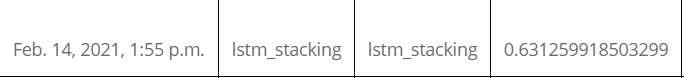

In [ ]:
#test_pid = pd.DataFrame([])
#for pid in list(test_dataset['pid'].unique())[0:100]:
#  test_pid_aux = test_dataset[test_dataset['pid']==pid]
#  test_pid = pd.concat([test_pid, test_pid_aux], axis = 0)


In [ ]:
#for pred in pred_edg.index:
#  if np.isnan(pred_edg['new'][pred]):
#    pred_edg['new'][pred]=pred_edg['target'][pred]

In [ ]:
#mean_squared_error(differe[(differe['pid']==360) | (differe['pid']==203)]["target"],differe[(differe['pid']==360) | (differe['pid']==203)]["new"])

0.8727121296695675

#### Details for one pid

##### Set seed and retrieve train pid dataset

In [ ]:
test_360=test_dataset[test_dataset['pid']==10]

In [ ]:
test_360.shape

(346, 507)

In [ ]:
test_360["target"]=None

In [ ]:
train_360 = train_dataset[train_dataset['pid'] == 10]

In [ ]:
all_360=pd.concat([train_360,test_360])

In [ ]:
all_360 = all_360.set_index(['day'])

In [ ]:
all_360.shape[0]

1147

In [ ]:
SEED = 42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(SEED)

##### Split Data

In [ ]:
train_size = int((all_360.shape[0]-346) * 0.55)
valid_size = (all_360.shape[0]-346)- train_size
print("train size is:",train_size)
print("validation size is:",valid_size)
train_data = all_360.iloc[0:train_size,:]
valid_data = all_360.iloc[train_size:train_size+valid_size,:]
print("train data shape is:",train_data.shape)
print("validation data shape is:",valid_data.shape)

Multi-Dimensional Sliding Window

In [ ]:
###  This function creates a sliding window or sequences of seq_length days and labels_length  days label ####
def sliding_windows(data, seq_length,labels_length):
    x = []
    y = []
    z = []

    for i in range(len(data)-(seq_length+labels_length)):
        _x = data.iloc[i:(i+seq_length),:]
        _y = data.iloc[(i+seq_length):(i+seq_length+labels_length),506:507]
        _z  = data.iloc[(i+seq_length):(i+seq_length+labels_length),:506]
        x.append(np.array(_x))
        y.append(np.array(_y))
        z.append(np.array(_z))

    return x,y,z

We will use a sliding window of 10 days Our target(labels) is 100 days









In [ ]:
seq_length = 10
labels_length = 346
train_X, train_y,train_features = sliding_windows(train_data, seq_length,labels_length)
print("train X  has:", len(train_X) , "series")
print("train labels  has:", len(train_y) , "series")
valid_X, valid_y,valid_features = sliding_windows(valid_data, seq_length,labels_length)
print("validiation  X  has:", len(valid_X) , "series")
print("Validiation  labels  has:" ,len(valid_y) , "series")

##### Plot Example

To verify the concept Let's plot

    The original TS (take the length of the sliding window + the label size - 90 days + 28 days)
    The first array of trainX - which is the first sequence
    The first array of trainy , which is the first label


In [ ]:
plt.figure(figsize=(15,17))
fig, axs =plt.subplots(3,figsize=(12,9))

axs[0].plot(train_data[0:seq_length+labels_length])
axs[0].title.set_text('Original Time Series')
axs[0].set_xlim(0,seq_length+labels_length)
axs[0].set_ylim(-1,1)
axs[1].plot(train_X[0].flatten(),color="red")
axs[1].title.set_text('Train Data')
axs[1].set_xlim(0,seq_length+labels_length)
axs[1].set_ylim(-1,1)
axs[2].plot(np.pad(train_y[0].flatten(),seq_length),color='black')
axs[2].title.set_text('Labels Data')
axs[2].set_xlim(0,seq_length+labels_length)
axs[2].set_ylim(-1,1)



In [ ]:
train_X[0].shape

In [ ]:
train_y[0].shape

In [ ]:
train_features[0].shape

Convert to Pytorch Tensors

In [ ]:
trainX = Variable(torch.Tensor(train_X))
trainy = Variable(torch.Tensor(train_y))
train_features = Variable(torch.Tensor(train_features))
validX = Variable(torch.Tensor(valid_X))
validy= Variable(torch.Tensor(valid_y))
valid_features = Variable(torch.Tensor(valid_features))


print ("trainX shape is:",trainX.size())
print ("trainy shape is:",trainy.size())
print ("train features  shape is:",train_features.size())
print ("validX shape is:",validX.size())
print ("validy shape is:",validy.size())
print ("valid features  shape is:",valid_features.size())

Seq2Seq Model

Encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim,  embedding_dim
        self.num_layers = 3
        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=3,
          batch_first=True,
          dropout = 0.35
        )
   
    def forward(self, x):
       
        x = x.reshape((1, self.seq_len, self.n_features))
        
        h_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_dim).to(device))
         
        
        c_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_dim).to(device))
              
        x, (hidden, cell) = self.rnn1(x,(h_1, c_1))
        
        
        #return hidden_n.reshape((self.n_features, self.embedding_dim))
        return hidden , cell 

Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()

        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features =  input_dim, n_features
        
        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=input_dim,
          num_layers=3,
          batch_first=True,
          dropout = 0.35
        )
        
        
      
        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x,input_hidden,input_cell):
       
       
        x = x.reshape((1,1,self.n_features ))
        #print("decode input",x.size())
             

        x, (hidden_n, cell_n) = self.rnn1(x,(input_hidden,input_cell))
    
        x = self.output_layer(x)
        return x, hidden_n, cell_n

Seq2Seq

In [ ]:
class Seq2Seq(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64,output_length = 346):
        super(Seq2Seq, self).__init__()

        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.n_features = n_features
        self.output_length = output_length
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
        

    def forward(self,x, prev_y,features):
        
       
        hidden,cell = self.encoder(x)
         
        #Prepare place holder for decoder output
        targets_ta = []
        #prev_output become the next input to the LSTM cell
        dec_input = prev_y
        
        
        
       #dec_input = torch.cat([prev_output, curr_features], dim=1) 
        
        #itearate over LSTM - according to the required output days
        for out_days in range(self.output_length) :
            
          
            prev_x,prev_hidden,prev_cell = self.decoder(dec_input,hidden,cell)
            hidden,cell = prev_hidden,prev_cell
            
            prev_x = prev_x[:,:,0:1]
            #print("preve x shape is:",prev_x.size())
            #print("features shape is:",features[out_days+1].size())
            
            if out_days+1 < self.output_length :
                dec_input = torch.cat([prev_x,features[out_days+1].reshape(1,1,506)], dim=2) 
            
            targets_ta.append(prev_x.reshape(1))
           
            
        
        
        targets = torch.stack(targets_ta)

        return targets

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
n_features = trainX.shape[2]
model = Seq2Seq(seq_length, n_features, 512)
model = model.to(device)
model

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

In [ ]:
def train_model(model, TrainX,Trainy,ValidX,Validy,seq_length, n_epochs):
  
    history = dict(train=[], val=[])

    #best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
    mb = master_bar(range(1, n_epochs + 1))

    for epoch in mb:
        model = model.train()

        train_losses = []
        for i in progress_bar(range(TrainX.size()[0]),parent=mb):
            seq_inp = TrainX[i,:,:].to(device)
            seq_true = Trainy[i,:,:].to(device)
            features = train_features[i,:,:].to(device)
           
            optimizer.zero_grad()

            
            seq_pred = model(seq_inp,seq_inp[seq_length-1:seq_length,:],features)
            
            
            loss = criterion(seq_pred, seq_true)

            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()

            train_losses.append(loss.item())

        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for i in progress_bar(range(validX.size()[0]),parent=mb):
                seq_inp = ValidX[i,:,:].to(device)
                seq_true = Validy[i,:,:].to(device)
                features = valid_features[i,:,:].to(device)
        
                seq_pred = model(seq_inp,seq_inp[seq_length-1:seq_length,:],features)
               

                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), 'best_model_n_features.pt')
            print("saved best model epoch:",epoch,"val loss is:",val_loss)

        
        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
        scheduler.step(val_loss)
    #model.load_state_dict(best_model_wts)
    return model.eval(), history

In [ ]:
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-2,weight_decay=1e-5)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = torch.nn.MSELoss().to(device) 
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 5e-3, eta_min=1e-8, last_epoch=-1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=10, factor =0.5 ,min_lr=1e-7, eps=1e-08)

In [ ]:
model, history = train_model(
  model,
  trainX,trainy,
  validX,validy,
  seq_length,
  n_epochs=1, #Train for few epochs as illustration, 
    
)

Predict

In [ ]:
all_360

In [ ]:
TestX = np.array(all_360.iloc[-692:-346,:])
Testy = np.array(all_360.iloc[-346:,:])

In [ ]:
TestX.shape

In [ ]:
TestX = Variable(torch.Tensor(TestX))
Testy = Variable(torch.Tensor(Testy))

In [ ]:
model.eval()

In [ ]:
train_360.iloc[:,:507]

In [ ]:
seq_inp[:,:507]

In [ ]:
with torch.no_grad():
  for i in progress_bar(range(validX.size()[0]),parent=mb):
    seq_inp = ValidX[i,:,:].to(device)
    seq_true = Validy[i,:,:].to(device)
    features = valid_features[i,:,:].to(device)
    seq_pred = model(seq_inp,seq_inp[seq_length-1:seq_length,:],features)
    loss = criterion(seq_pred, seq_true)
    val_losses.append(loss.item())

In [ ]:
validX[0,:,:].shape

In [ ]:
TestX.shape

In [ ]:
#model.eval()
with torch.no_grad():
    seq_inp = TestX.to(device)
    seq_pred = model(TestX[0:10,:].to(device),seq_inp[seq_length-1:seq_length,:],seq_inp[:,:506])

In [ ]:
seq_pred.shape

In [ ]:
len(seq_pred)

In [ ]:
data_predict = seq_pred.cpu().numpy()
labels = Testy

In [ ]:
data_predict.flatten()

In [ ]:
len(data_predict)

In [ ]:
original_data = all_360.iloc[-346:,:]

In [ ]:
final = pd.DataFrame(original_data['target'])

In [ ]:
final

In [ ]:
pred = data_predict.flatten()
pred_df = pd.DataFrame(pred)

In [ ]:
pred_df = pred_df.set_index([final.index])

In [ ]:
pred_df

In [ ]:
final['pred'] = pred_df

In [ ]:
final

In [ ]:
mean_squared_error(final['target'], final['pred'])

# Saving our notebook

In [ ]:
!jupyter nbconvert '/content/drive/MyDrive/U4_Prediction_stock_auction_volumes/notebook/New_model.ipynb' --to slides --post serve

[NbConvertApp] Converting notebook /content/drive/MyDrive/U4_Prediction_stock_auction_volumes/notebook/New_model.ipynb to slides
[NbConvertApp] Writing 1321361 bytes to /content/drive/MyDrive/U4_Prediction_stock_auction_volumes/notebook/New_model.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Serving your slides at http://127.0.0.1:8000/New_model.slides.html
Use Control-C to stop this server
[NbConvertApp] WARNING | No web browser found: could not locate runnable browser.

InterruptedTraceback (most recent call last):
  File "/usr/local/bin/jupyter-nbconvert", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python2.7/dist-packages/jupyter_core/application.py", line 267, in launch_instance
    return super(JupyterApp, cls).launch_instance(argv=argv, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/l

In [1]:
!jupyter nbconvert "C:\Users\swp\Documents\_Perso\Cours\M2\U4.Artificial_Intelligence\artificial_intelligence_for_finance\Git\U4_Prediction_stock_auction_volumes\notebook\New_model.ipynb" --to html_toc

[NbConvertApp] Converting notebook C:\Users\swp\Documents\_Perso\Cours\M2\U4.Artificial_Intelligence\artificial_intelligence_for_finance\Git\U4_Prediction_stock_auction_volumes\notebook\New_model.ipynb to html_toc
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\Scripts\jupyter-nbconvert-script.py", line 10, in <module>
    sys.exit(main())
  File "C:\ProgramData\Anaconda3\lib\site-packages\jupyter_core\application.py", line 254, in launch_instance
    return super(JupyterApp, cls).launch_instance(argv=argv, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\nbconvert\nbconvertapp.py", line 350, in start
    self.convert_notebooks()
  File "C:\ProgramData\Anaconda3\lib\site-packages\nbconvert\nbconvertapp.py", line 524, in convert_notebooks
    self.convert_single_notebook(notebook_filename)
  File "C:\ProgramData\Anaconda3\lib\s

In [2]:
!git clone https://github.com/hakimel/reveal.js.git
!cd reveal.js
!git checkout 3.5.0
!cd ..

Cloning into 'reveal.js'...
error: pathspec '3.5.0' did not match any file(s) known to git


In [3]:
!cd

C:\Users\swp\Documents\_Perso\Cours\M2\U4.Artificial_Intelligence\artificial_intelligence_for_finance\Git\U4_Prediction_stock_auction_volumes\notebook


In [6]:
!jupyter nbconvert C:\Users\swp\Documents\_Perso\Cours\M2\U4.Artificial_Intelligence\artificial_intelligence_for_finance\Git\U4_Prediction_stock_auction_volumes\notebook\New_model.ipynb --to slides --reveal-prefix reveal.js

[NbConvertApp] Converting notebook C:\Users\swp\Documents\_Perso\Cours\M2\U4.Artificial_Intelligence\artificial_intelligence_for_finance\Git\U4_Prediction_stock_auction_volumes\notebook\New_model.ipynb to slides
[NbConvertApp] Writing 1764638 bytes to C:\Users\swp\Documents\_Perso\Cours\M2\U4.Artificial_Intelligence\artificial_intelligence_for_finance\Git\U4_Prediction_stock_auction_volumes\notebook\New_model.slides.html
